# LAMC-DMD

> **Low-Rank Autoregressive Matrix Completion with Dynamic Mode Decomposition**

In this post, I will discuss the following content with you:

- The basic idea of low-rank matrix completion
- The fundamental of dynamic mode decomposition
- How to build a low-rank autoregressive matrix completion by using dynamic mode decomposition?

For your better understanding, I will also introduce the Python implementation of these models.

In this notebook, we need to import some necessary packages that will be used in the following models (e.g., `numpy`, `matplotlib`).

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

### Low-Rank Matrix Completion

First of all, let us get started by answering the following two questions.

- How to fill in the data matrix of low rank?
- What is the main idea of low-rank matrix completion?

There is a small example about traffic volume matrix consisting of 5 spatial locations and 4 time points:

\begin{equation}
\boldsymbol{Y}=\left[\begin{array}{cccc}
\color{red}{?} & 99 & 449 & 517\\
\color{red}{?} & \color{red}{?} & 412 & \color{red}{?}\\
192 & \color{red}{?} & 697 & 687\\
185 & \color{red}{?} & 699 & 657\\
164 & 58 & \color{red}{?} & \color{red}{?}\\
\end{array}\right]\in\mathbb{R}^{5\times 4}
\end{equation}
where $?$ indicates the missing value.

We can use 0 to indicate the missing values in the `Numpy` matrix.

In [2]:
Y = np.array([[0, 99, 449, 517], 
              [0, 0, 412, 0],
              [192, 0, 697, 687], 
              [185, 0, 699, 657], 
              [164, 58, 0, 0]])

To fill in the data matrix of low rank, we can build a rank minimization model for the partially observed matrix $\boldsymbol{Y}\in\mathbb{R}^{M\times T}$:
\begin{equation}
\begin{aligned}
&\operatorname{min}_{\boldsymbol{X}}~\operatorname{rank}(\boldsymbol{X}) \\
&\text{s.t.}~\mathcal{P}_{\Omega}(\boldsymbol{X})=\mathcal{P}_{\Omega}(\boldsymbol{Y}),
\end{aligned}
\end{equation}
where $\mathcal{P}_{\Omega}:\mathbb{R}^{M\times T}\mapsto\mathbb{R}^{M\times T}$ is an orthogonal projection supported on the observed index set $\Omega$.
    
This is a low-rank matrix completion problem. Convex surrogate of rank minimization is nuclear norm minimization:
\begin{equation}
\begin{aligned}
&\operatorname{min}_{\boldsymbol{X}}~\|\boldsymbol{X}\|_{*} \\
&\text{s.t.}~\mathcal{P}_{\Omega}(\boldsymbol{X})=\mathcal{P}_{\Omega}(\boldsymbol{Y}).
\end{aligned}
\end{equation}

We can use ADMM solver to solve this problem.

In [95]:
def svt(mat, tau):
    u, s, v = np.linalg.svd(mat, full_matrices = False)
    idx = np.sum(s > tau)
    return u[:, : idx] @ np.diag(s[: idx] - tau) @ v[: idx, :]

def lrmc_imputer(mat, rho0, epsilon, maxiter):
    dim1, dim2 = mat.shape
    pos_missing = np.where(mat == 0)
    last_mat = mat.copy()
    snorm = np.linalg.norm(mat, 'fro')
    T = np.zeros((dim1, dim2))
    Z = mat.copy()
    Z[pos_missing] = np.mean(Z[Z != 0])
    it = 0
    rho = rho0
    while True:
        rho = min(rho * 1.05, 1e5)
        X = svt(Z - T / rho, 1 / rho)
        Z[pos_missing] = (X + T / rho)[pos_missing]
        T = T + rho * (X - Z)
        tol = np.linalg.norm((X - last_mat), 'fro') / snorm
        last_mat = X.copy()
        it += 1
        if it % 1 == 0:
            print('Iter: {}'.format(it))
            print('Tolerance: {:.6}'.format(tol))
            print()
        if (tol < epsilon) or (it >= maxiter):
            break
    return X

In [5]:
def compute_mape(var, var_hat):
    return np.sum(np.abs(var - var_hat) / var) / var.shape[0]

def compute_rmse(var, var_hat):
    return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])

**Ground truth**

\begin{equation}
\boldsymbol{Y}_{\text{true}}=\left[\begin{array}{cccc}
208 & 99 & 449 & 517 \\
104 & 43 & 412 & 411 \\
192 & 77 & 697 & 687 \\
185 & 115 & 699 & 657 \\
164 & 58 & 696 & 599
\end{array}\right]
\end{equation}

In [6]:
Y_true = np.array([[208, 99, 449, 517], 
                   [104, 43, 412, 411], 
                   [192, 77, 697, 687], 
                   [185, 115, 699, 657], 
                   [164, 58, 696, 599]])

In [7]:
import time
start = time.time()
rho = 1e-2
epsilon = 1e-4
maxiter = 50
mat_hat = lrmc_imputer(Y, rho, epsilon, maxiter)
end = time.time()
print('Running time: %d seconds.'%(end - start))

Running time: 0 seconds.


In [8]:
print('Input data:')
print(Y)
print()
print('Output data:')
print(mat_hat)
print()
pos = np.where((Y_true !=0) & (Y == 0))
print('MAPE:')
print(compute_mape(Y_true[pos], mat_hat[pos]))
print()
print('RMSE:')
print(compute_rmse(Y_true[pos], mat_hat[pos]))
print()

Input data:
[[  0  99 449 517]
 [  0   0 412   0]
 [192   0 697 687]
 [185   0 699 657]
 [164  58   0   0]]

Output data:
[[159.04847099  99.18262652 449.00102535 516.95501776]
 [ 99.8742826   56.87573812 412.07832117 373.81811694]
 [192.04406419 114.61567691 696.9467637  687.10518913]
 [184.9881024  104.77190083 698.98562741 657.05433582]
 [163.9969811   58.0294802  223.1162037  257.93166582]]

MAPE:
0.31430686733137786

RMSE:
207.80235466066495



**Imputation result**

\begin{equation}
\boldsymbol{Y}_{\text{true}}=\left[\begin{array}{cccc}
\color{red}{208} & 99 & 449 & 517 \\
\color{red}{104} & \color{red}{43} & 412 & \color{red}{411} \\
192 & \color{red}{77} & 697 & 687 \\
185 & \color{red}{115} & 699 & 657 \\
164 & 58 & \color{red}{696} & \color{red}{599}
\end{array}\right]\quad \text{vs.}\quad
\hat{\boldsymbol{Y}}=\left[\begin{array}{cccc}
\color{red}{159} & 99 & 449 & 517 \\
\color{red}{100} & \color{red}{57} & 412 & \color{red}{374} \\
192 & \color{red}{115} & 697 & 687 \\
185 & \color{red}{105} & 699 & 657 \\
164 & 58 & \color{red}{223} & \color{red}{258}
\end{array}\right]
\end{equation}

Comments:

- Low-rank matrix completion is an algebraic solution, which is well-suited for imputing missing values.
- Low-rank matrix completion is incapable of modeling temporal dynamics for multivariate time series data.

### Dynamic Mode Decomposition

Dynamic mode decomposition (DMD) is a powerful tool for spatiotemporal modeling. Unlike other low-rank matrix completion algorithms, the DMD is capable of modeling time series dynmaics and can be used to make short-term future prediction.

Basic formulation:

$$\boldsymbol{x}_{t}\approx\boldsymbol{A}\boldsymbol{x}_{t-1}$$ where $\boldsymbol{A}$ is the **Koopman** matrix.


The DMD is implemented as follows:

> [**Step 1**] Build a spatiotemporal matrix $\boldsymbol{X}\in\mathbb{R}^{M\times T}$ consisting of $M$ spatial sensors/locations and $T$ time points.

> [**Step 2**] Construct two sub-matrices: $$\boldsymbol{X}_{1}=\left[\boldsymbol{x}_1,\boldsymbol{x}_2,\cdots,\boldsymbol{x}_{T-1}\right]$$ and $$\boldsymbol{X}_{2}=\left[\boldsymbol{x}_2,\boldsymbol{x}_3,\cdots,\boldsymbol{x}_{T}\right]$$

> [**Step 3**] Compute the singular value decomposition of $\boldsymbol{X}_1$: $$\boldsymbol{X}_1=\boldsymbol{U}\boldsymbol{\Sigma}\boldsymbol{V}^\top$$

[**Python code**]
```python
u, s, v = np.linalg.svd(X1, full_matrices = False)
```

> [**Step 4**] Approximate the Koopman matrix $\boldsymbol{A}\in\mathbb{R}^{M\times M}$ by $\tilde{\boldsymbol{A}}\in\mathbb{R}^{R\times R}$ ($R<M$): $$\tilde{\boldsymbol{A}}=\boldsymbol{U}^\top\boldsymbol{X}_2\boldsymbol{V}\boldsymbol{\Sigma}^{-1}$$ where $\boldsymbol{U}:=\boldsymbol{U}_{1:R}\in\mathbb{R}^{M\times R}$, $\boldsymbol{V}:=\boldsymbol{V}_{1:R}\in\mathbb{R}^{T\times R}$, and $\boldsymbol{\Sigma}:=\boldsymbol{\Sigma}_{1:R}\in\mathbb{R}^{R\times R}$.

[**Python code**]
```python
A_tilde = u[:, : rank].T @ X2 @ v[: rank, :].T @ np.linalg.inv(np.diag(s[: rank]))
```
> [**Step 5**] Compute the eigenvalue decomposition of $\tilde{\boldsymbol{A}}$: $$\tilde{\boldsymbol{A}}=\boldsymbol{D}\boldsymbol{\Lambda}\boldsymbol{D}^{-1}$$ where $\boldsymbol{d}_1,...,\boldsymbol{d}_R$ are eigenvectors and $\lambda_1,...,\lambda_R$ are eigenvalues.

[**Python code**]
```python
Lambda, D = np.linalg.eig(A_tilde)
```

> [**Step 6**] Compute the estimated $\hat{\boldsymbol{X}}_2$: $$\hat{\boldsymbol{X}}_2={\Phi}\boldsymbol{\Lambda}({\Phi}^+\boldsymbol{X}_1)$$ where $$\Phi=\boldsymbol{X}_1\boldsymbol{V}^\top\boldsymbol{\Sigma}^{-1}\boldsymbol{D}$$

In [9]:
def dmd(X1, X2, rank):
    """Dynamic Mode Decomposition, DMD."""
    
    u, s, v = np.linalg.svd(X1, full_matrices = 0)
    A_tilde = u[:, : rank].T @ X2 @ v[: rank, :].T @ np.linalg.inv(np.diag(s[: rank]))
    Lambda, D = np.linalg.eig(A_tilde)
    Phi = X1 @ v[: rank, :].T @ np.linalg.inv(np.diag(s[: rank])) @ D
    A = Phi @ np.diag(Lambda)
    pinv_Phi = np.linalg.pinv(Phi)
    temp = A @ (pinv_Phi @ X1)
    
    return temp.real, A, pinv_Phi

### Bidirectional DMD

- **Forward DMD**: $\boldsymbol{x}_{t}=\boldsymbol{A}_{f}\boldsymbol{x}_{t-1},\forall t$

- **Backward DMD**: $\boldsymbol{x}_{t}=\boldsymbol{A}_{b}\boldsymbol{x}_{t+1},\forall t$

DMD regularizer:
\begin{equation}
\|\boldsymbol{X}\|_{\text{DMD}}=\left\{\begin{array}{ll}
\sum_{t=2}^{T}\|\boldsymbol{x}_{t}-\boldsymbol{A}_{f}\boldsymbol{x}_{t-1}\|_{2}^{2}+\sum_{t=1}^{T-1}\|\boldsymbol{x}_{t}-\boldsymbol{A}_{b}\boldsymbol{x}_{t+1}\|_{2}^{2}, & \text{if bidirection is true,} \\ 
\sum_{t=2}^{T}\|\boldsymbol{x}_{t}-\boldsymbol{A}_{f}\boldsymbol{x}_{t-1}\|_{2}^{2}, & \text{if bidirection is false.} \\ 
\end{array}\right.
\end{equation}

### Low-Rank Autoregressive Matrix Completion

By putting low-rank matrix completion and dynamic mode decomposition together, we could build a low-rank autoregressive matrix completion model as follows,
\begin{equation}
\begin{aligned}
&\operatorname{min}_{\boldsymbol{X},\boldsymbol{Z},\boldsymbol{A}}~\|\boldsymbol{X}\|_{*}+\frac{\lambda}{2}\|\boldsymbol{Z}\|_{\text{DMD}} \\
&\text{s.t.}~\left\{\begin{array}{l}
\boldsymbol{X}=\boldsymbol{Z}, \\
\mathcal{P}_{\Omega}(\boldsymbol{Z})=\mathcal{P}_{\Omega}(\boldsymbol{Y}), \\
\end{array}\right. \\
\end{aligned}
\end{equation}
where $\|\cdot\|_{\text{DMD}}$ denotes the DMD regularizer.


Low-Rank Matrix Completion + Dynamic Mode Decomposition

In [204]:
def lamc_imputer(dense_mat, sparse_mat, rho, lambda0, epsilon, maxiter, rank = 50):
    """Low-Rank Autoregressive Matrix Completion, LAMC-imputer."""
    
    dim1, dim2 = sparse_mat.shape
    pos_test = np.where((dense_mat != 0) & (sparse_mat == 0))
    dense_test = dense_mat[pos_test]
    del dense_mat
    Tf = np.zeros((dim1, dim2 - 1))
    Tb = np.zeros((dim1, dim2 - 1))
    X = sparse_mat[:, 1 :]
    indx = X != 0
    Z = sparse_mat[:, : dim2 - 1]
    indz = Z != 0
    it = 0
    last_mat = sparse_mat
    snorm = np.linalg.norm(sparse_mat, 'fro')
    while True:
        temp, _, _ = dmd(Z, X, rank)
        X = svt(Tf / lambda0 + temp, 1 / lambda0)
        Tf = Tf + rho * (sparse_mat[:, 1 :] - X) * indx
        temp, _, _ = dmd(X, Z, rank)
        Z = svt(Tb / lambda0 + temp, 1 / lambda0)
        Tb = Tb + rho * (sparse_mat[:, : dim2 - 1] - Z) * indz
        mat_hat = 0.5 * (np.append(Z, X[:, -1].reshape([dim1, 1]), axis = 1)
                         + np.append(Z[:, 0].reshape([dim1, 1]), X, axis = 1))
        X[np.where(1 - indx)] = (mat_hat[:, 1 :])[np.where(1 - indx)]
        Z[np.where(1 - indz)] = (mat_hat[:, : dim2 - 1])[np.where(1 - indz)]
        tol = np.linalg.norm((mat_hat - last_mat), 'fro') / snorm
        last_mat = mat_hat.copy()
        it += 1
        if it % 10 == 0:
            print('Iter: {}'.format(it))
            print('Tolerance: {:.6}'.format(tol))
            print('MAPE: {:.6}'.format(compute_mape(dense_test, mat_hat[pos_test])))
            print('RMSE: {:.6}'.format(compute_rmse(dense_test, mat_hat[pos_test])))
            print()
        if (tol < epsilon) or (it >= maxiter):
            break

    print('Total iteration: {}'.format(it))
    print('Tolerance: {:.6}'.format(tol))
    print('Imputation MAPE: {:.6}'.format(compute_mape(dense_test, mat_hat[pos_test])))
    print('Imputation RMSE: {:.6}'.format(compute_rmse(dense_test, mat_hat[pos_test])))
    print()
    
    return mat_hat

In [232]:
import numpy as np
import pandas as pd
np.random.seed(1000)

data = pd.read_csv('../datasets/California-data-set/pems-4w.csv', header = None)
dense_mat = data.values[:, : 1 * 288]

missing_rate = 0.3

### Random missing (RM)
sparse_mat = dense_mat * np.round(np.random.rand(dense_mat.shape[0], dense_mat.shape[1]) + 0.5 - missing_rate)
del data

In [213]:
import time
start = time.time()
rho = 1e-4
epsilon = 1e-4
maxiter = 100
mat_hat = lrmc_imputer(sparse_mat, rho, epsilon, maxiter)
pos_test = np.where((dense_mat != 0) & (sparse_mat == 0))
print('Imputation MAPE: {:.6}'.format(compute_mape(dense_mat[pos_test], mat_hat[pos_test])))
print('Imputation RMSE: {:.6}'.format(compute_rmse(dense_mat[pos_test], mat_hat[pos_test])))
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 1
Tolerance: 2.7499

Iter: 2
Tolerance: 0.195661

Iter: 3
Tolerance: 0.126371

Iter: 4
Tolerance: 0.0617196

Iter: 5
Tolerance: 0.0442671

Iter: 6
Tolerance: 0.0835358

Iter: 7
Tolerance: 0.118622

Iter: 8
Tolerance: 0.138651

Iter: 9
Tolerance: 0.142935

Iter: 10
Tolerance: 0.133457

Iter: 11
Tolerance: 0.113618

Iter: 12
Tolerance: 0.087681

Iter: 13
Tolerance: 0.060678

Iter: 14
Tolerance: 0.0396863

Iter: 15
Tolerance: 0.0349119

Iter: 16
Tolerance: 0.0444259

Iter: 17
Tolerance: 0.0562617

Iter: 18
Tolerance: 0.0637375

Iter: 19
Tolerance: 0.0653395

Iter: 20
Tolerance: 0.0615615

Iter: 21
Tolerance: 0.0542316

Iter: 22
Tolerance: 0.0454277

Iter: 23
Tolerance: 0.0372657

Iter: 24
Tolerance: 0.0316692

Iter: 25
Tolerance: 0.0292012

Iter: 26
Tolerance: 0.0288779

Iter: 27
Tolerance: 0.0292698

Iter: 28
Tolerance: 0.0294302

Iter: 29
Tolerance: 0.0289226

Iter: 30
Tolerance: 0.0277403

Iter: 31
Tolerance: 0.0258353

Iter: 32
Tolerance: 0.0235307

Iter: 33
Tolerance: 0.0212392

In [237]:
import time
start = time.time()
rho = 0.1
lambda0 = 10 * rho
epsilon = 1e-4
maxiter = 200
mat_hat = lamc_imputer(dense_mat, sparse_mat, rho, lambda0, epsilon, maxiter, rank = 50)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 10
Tolerance: 0.0653729
MAPE: 0.120059
RMSE: 9.06586

Iter: 20
Tolerance: 0.0630104
MAPE: 0.0873958
RMSE: 7.22528

Iter: 30
Tolerance: 0.0532658
MAPE: 0.119144
RMSE: 9.53048

Iter: 40
Tolerance: 0.0451459
MAPE: 0.120031
RMSE: 9.35948

Iter: 50
Tolerance: 0.0412729
MAPE: 0.0923153
RMSE: 7.36886

Iter: 60
Tolerance: 0.0376654
MAPE: 0.0711016
RMSE: 5.78873

Iter: 70
Tolerance: 0.0340148
MAPE: 0.0587585
RMSE: 4.85201

Iter: 80
Tolerance: 0.0318461
MAPE: 0.0496678
RMSE: 4.16013

Iter: 90
Tolerance: 0.0303819
MAPE: 0.0431112
RMSE: 3.66984

Iter: 100
Tolerance: 0.0290676
MAPE: 0.0388069
RMSE: 3.36116

Iter: 110
Tolerance: 0.0283025
MAPE: 0.0359799
RMSE: 3.15797

Iter: 120
Tolerance: 0.0275865
MAPE: 0.0338444
RMSE: 3.01992

Iter: 130
Tolerance: 0.0270929
MAPE: 0.0324079
RMSE: 2.93365

Iter: 140
Tolerance: 0.0268605
MAPE: 0.0310769
RMSE: 2.84336

Iter: 150
Tolerance: 0.0266611
MAPE: 0.0300637
RMSE: 2.77481

Iter: 160
Tolerance: 0.0267028
MAPE: 0.0293135
RMSE: 2.72622

Iter: 170
Tolerance:

In [135]:
import time
start = time.time()
rho = 0.2
lambda0 = 5
epsilon = 1e-4
maxiter = 100
mat_hat = lamc_imputer(dense_mat, sparse_mat, rho, lambda0, epsilon, maxiter, rank = 2)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 1
Tolerance: 0.947193
MAPE: 0.899823
RMSE: 59.1291

Iter: 2
Tolerance: 0.29951
MAPE: 0.810185
RMSE: 53.3351

Iter: 3
Tolerance: 0.267806
MAPE: 0.730016
RMSE: 48.1554

Iter: 4
Tolerance: 0.239256
MAPE: 0.658302
RMSE: 43.5237

Iter: 5
Tolerance: 0.213887
MAPE: 0.594125
RMSE: 39.3801

Iter: 6
Tolerance: 0.191343
MAPE: 0.536668
RMSE: 35.671

Iter: 7
Tolerance: 0.171306
MAPE: 0.485204
RMSE: 32.3488

Iter: 8
Tolerance: 0.15348
MAPE: 0.439088
RMSE: 29.3712

Iter: 9
Tolerance: 0.137607
MAPE: 0.397743
RMSE: 26.7009

Iter: 10
Tolerance: 0.123468
MAPE: 0.360657
RMSE: 24.3048

Iter: 11
Tolerance: 0.110868
MAPE: 0.327382
RMSE: 22.1535

Iter: 12
Tolerance: 0.0996355
MAPE: 0.297514
RMSE: 20.2212

Iter: 13
Tolerance: 0.0896152
MAPE: 0.270695
RMSE: 18.4848

Iter: 14
Tolerance: 0.0806702
MAPE: 0.246603
RMSE: 16.9242

Iter: 15
Tolerance: 0.0726797
MAPE: 0.22495
RMSE: 15.5215

Iter: 16
Tolerance: 0.065537
MAPE: 0.205483
RMSE: 14.2605

Iter: 17
Tolerance: 0.0591478
MAPE: 0.187977
RMSE: 13.1272

Iter:

In [141]:
import time
start = time.time()
rho = 100
lambda0 = 100
epsilon = 1e-4
maxiter = 100
mat_hat = lamc_imputer(dense_mat, sparse_mat, rho, lambda0, epsilon, maxiter, rank = 2)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 1
Tolerance: 0.947193
MAPE: 0.899821
RMSE: 59.129

Iter: 2
Tolerance: 1.0253
MAPE: 0.809779
RMSE: 53.3049

Iter: 3
Tolerance: 0.244793
MAPE: 0.729436
RMSE: 48.1139

Iter: 4
Tolerance: 0.218164
MAPE: 0.657614
RMSE: 43.4757

Iter: 5
Tolerance: 0.195304
MAPE: 0.593374
RMSE: 39.3273

Iter: 6
Tolerance: 0.175175
MAPE: 0.535876
RMSE: 35.6135

Iter: 7
Tolerance: 0.157309
MAPE: 0.484386
RMSE: 32.2854

Iter: 8
Tolerance: 0.141434
MAPE: 0.438246
RMSE: 29.3004

Iter: 9
Tolerance: 0.127304
MAPE: 0.396876
RMSE: 26.6212

Iter: 10
Tolerance: 0.114707
MAPE: 0.359762
RMSE: 24.215

Iter: 11
Tolerance: 0.103457
MAPE: 0.326456
RMSE: 22.0529

Iter: 12
Tolerance: 0.0933936
MAPE: 0.296556
RMSE: 20.1096

Iter: 13
Tolerance: 0.08438
MAPE: 0.269703
RMSE: 18.3625

Iter: 14
Tolerance: 0.0762965
MAPE: 0.245575
RMSE: 16.7918

Iter: 15
Tolerance: 0.0690387
MAPE: 0.223886
RMSE: 15.3797

Iter: 16
Tolerance: 0.0625158
MAPE: 0.204382
RMSE: 14.1106

Iter: 17
Tolerance: 0.0566478
MAPE: 0.18684
RMSE: 12.9703

Iter: 1

In [212]:
import time
start = time.time()
rho = 1
lambda0 = 0.5 * rho
epsilon = 1e-4
maxiter = 100
mat_hat = lamc_imputer(dense_mat, sparse_mat, rho, lambda0, epsilon, maxiter, rank = 10)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 10
Tolerance: 0.616594
MAPE: 0.396623
RMSE: 27.381

Iter: 20
Tolerance: 0.296026
MAPE: 0.183682
RMSE: 14.2529

Iter: 30
Tolerance: 0.200987
MAPE: 0.107112
RMSE: 9.27023

Iter: 40
Tolerance: 0.156276
MAPE: 0.0741999
RMSE: 7.13171

Iter: 50
Tolerance: 0.124879
MAPE: 0.0581378
RMSE: 6.16183

Iter: 60
Tolerance: 0.194727
MAPE: 0.0463466
RMSE: 5.16428

Iter: 70
Tolerance: 0.434693
MAPE: 0.0362152
RMSE: 3.54965

Iter: 80
Tolerance: 0.518066
MAPE: 0.032604
RMSE: 3.3156

Iter: 90
Tolerance: 0.54491
MAPE: 0.031653
RMSE: 3.27576

Iter: 100
Tolerance: 0.56528
MAPE: 0.0314312
RMSE: 3.2681

Total iteration: 100
Tolerance: 0.56528
Imputation MAPE: 0.0314312
Imputation RMSE: 3.2681

Running time: 113 seconds


In [185]:
import time
start = time.time()
rho = 1
lambda0 = 0.5 * rho
epsilon = 1e-4
maxiter = 100
mat_hat = lamc_imputer(dense_mat, sparse_mat, rho, lambda0, epsilon, maxiter, rank = 5)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 10
Tolerance: 0.67053
MAPE: 0.378996
RMSE: 25.5053

Iter: 20
Tolerance: 0.277403
MAPE: 0.149498
RMSE: 10.9946

Iter: 30
Tolerance: 0.171164
MAPE: 0.0739944
RMSE: 6.19094

Iter: 40
Tolerance: 0.130914
MAPE: 0.0473866
RMSE: 4.51879

Iter: 50
Tolerance: 0.105968
MAPE: 0.0377138
RMSE: 3.94802

Iter: 60
Tolerance: 0.162657
MAPE: 0.0325478
RMSE: 3.39844

Iter: 70
Tolerance: 0.123829
MAPE: 0.0290875
RMSE: 3.07653

Iter: 80
Tolerance: 0.112912
MAPE: 0.0279985
RMSE: 3.02411

Iter: 90
Tolerance: 0.10362
MAPE: 0.0275351
RMSE: 2.99111

Iter: 100
Tolerance: 0.0978852
MAPE: 0.0274823
RMSE: 2.98963

Total iteration: 100
Tolerance: 0.0978852
Imputation MAPE: 0.0274823
Imputation RMSE: 2.98963

Running time: 109 seconds


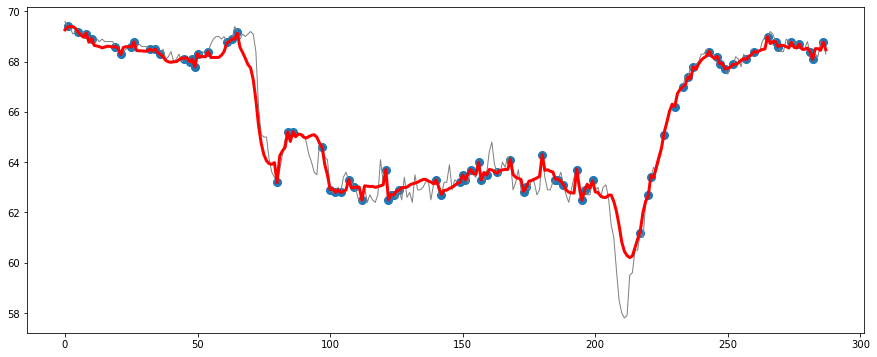

In [226]:
import matplotlib.pyplot as plt

loc = 2
pos = np.where(sparse_mat[loc, :] != 0)
fig = plt.figure(figsize = (15, 6))
plt.plot(pos[0], sparse_mat[loc, pos[0]], 'o', markersize = 8)
plt.plot(dense_mat[loc, :], color = 'gray', linewidth = 1)
plt.plot(mat_hat[loc, :], color = 'red', linewidth = 3)
plt.show()

In [202]:
dense_mat.shape

(11160, 288)

In [203]:
mat_hat.shape

(11160, 287)

In [110]:
import time
start = time.time()
rho = 0.01
lambda0 = 0.1
epsilon = 1e-4
maxiter = 100
mat_hat = lamc_imputer(dense_mat, sparse_mat, rho, lambda0, epsilon, maxiter, rank = 2)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 1
Tolerance: 0.518016
MAPE: 0.449742
RMSE: 31.5296

Iter: 2
Tolerance: 0.213404
MAPE: 0.237834
RMSE: 18.4172

Iter: 3
Tolerance: 0.0973652
MAPE: 0.144792
RMSE: 12.7029

Iter: 4
Tolerance: 0.0543274
MAPE: 0.100371
RMSE: 10.1406

Iter: 5
Tolerance: 0.0324949
MAPE: 0.078609
RMSE: 8.91313

Iter: 6
Tolerance: 0.0202484
MAPE: 0.067498
RMSE: 8.21104

Iter: 7
Tolerance: 0.0150254
MAPE: 0.060824
RMSE: 7.70498

Iter: 8
Tolerance: 0.0125874
MAPE: 0.0559466
RMSE: 7.28579

Iter: 9
Tolerance: 0.0118407
MAPE: 0.0520712
RMSE: 6.92736

Iter: 10
Tolerance: 0.0101408
MAPE: 0.0488722
RMSE: 6.6081

Iter: 11
Tolerance: 0.00854787
MAPE: 0.0461675
RMSE: 6.33502

Iter: 12
Tolerance: 0.00796477
MAPE: 0.0438477
RMSE: 6.08446

Iter: 13
Tolerance: 0.0100393
MAPE: 0.0413867
RMSE: 5.79989

Iter: 14
Tolerance: 0.00937836
MAPE: 0.0391513
RMSE: 5.55071

Iter: 15
Tolerance: 0.00706545
MAPE: 0.0372633
RMSE: 5.32243

Iter: 16
Tolerance: 0.00819734
MAPE: 0.0354935
RMSE: 5.09975

Iter: 17
Tolerance: 0.00655593
MAPE: 0

### Experiments on Real-World Data

#### Guangzhou traffic speed data

**Case**: Random missing data (40% missing rate) imputation on the Guangzhou traffic speed data set.

In [83]:
import numpy as np
np.random.seed(1000)

missing_rate = 0.3

dense_mat = np.load('../datasets/London-data-set/hourly_speed_mat.npy')
binary_mat = dense_mat.copy()
binary_mat[binary_mat != 0] = 1
pos = np.where(np.sum(binary_mat, axis = 1) > 0.7 * binary_mat.shape[1])
dense_mat = dense_mat[pos[0], :]
dim1, dim2 = dense_mat.shape
del binary_mat

## Random missing (RM)
sparse_mat = dense_mat * np.round(np.random.rand(dim1, dim2) + 0.5 - missing_rate)

In [85]:
import time
start = time.time()
rho = 1e-4
epsilon = 1e-4
maxiter = 100
mat_hat = lrmc_imputer(sparse_mat, rho, epsilon, maxiter)
pos_test = np.where((dense_mat != 0) & (sparse_mat == 0))
print('Imputation MAPE: {:.6}'.format(compute_mape(dense_mat[pos_test], mat_hat[pos_test])))
print('Imputation RMSE: {:.6}'.format(compute_rmse(dense_mat[pos_test], mat_hat[pos_test])))
end = time.time()
print('Running time: %d seconds'%(end - start))

Imputation MAPE: 0.0879562
Imputation RMSE: 2.08665
Running time: 161 seconds


In [62]:
import time
start = time.time()
rho = 0.1
lambda0 = 0.1
epsilon = 1e-4
maxiter = 100
mat_hat = lamc_imputer(dense_mat, sparse_mat, rho, lambda0, epsilon, maxiter, rank = 80)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 1
Tolerance: 0.579596
MAPE: 0.389633
RMSE: 10.6227

Iter: 2
Tolerance: 0.574221
MAPE: 0.187483
RMSE: 5.79405

Iter: 3
Tolerance: 0.155138
MAPE: 0.131833
RMSE: 4.25592

Iter: 4
Tolerance: 0.0878425
MAPE: 0.115341
RMSE: 3.6419

Iter: 5
Tolerance: 0.0489697
MAPE: 0.108378
RMSE: 3.31488

Iter: 6
Tolerance: 0.0390091
MAPE: 0.104255
RMSE: 3.10569

Iter: 7
Tolerance: 0.0325666
MAPE: 0.10141
RMSE: 2.95879

Iter: 8
Tolerance: 0.0270549
MAPE: 0.099444
RMSE: 2.85092

Iter: 9
Tolerance: 0.0222359
MAPE: 0.0980259
RMSE: 2.76876

Iter: 10
Tolerance: 0.0211404
MAPE: 0.0968439
RMSE: 2.70123

Iter: 11
Tolerance: 0.0190647
MAPE: 0.0959308
RMSE: 2.64767

Iter: 12
Tolerance: 0.017009
MAPE: 0.0952254
RMSE: 2.60366

Iter: 13
Tolerance: 0.0150288
MAPE: 0.0946689
RMSE: 2.56698

Iter: 14
Tolerance: 0.0138177
MAPE: 0.0942052
RMSE: 2.53544

Iter: 15
Tolerance: 0.0126644
MAPE: 0.0938124
RMSE: 2.50788

Iter: 16
Tolerance: 0.0114431
MAPE: 0.0934871
RMSE: 2.48388

Iter: 17
Tolerance: 0.0106072
MAPE: 0.0932056
R

In [60]:
import time
start = time.time()
rho = 0.1
lambda0 = 0.1
epsilon = 1e-4
maxiter = 100
mat_hat = lamc_imputer(dense_mat, sparse_mat, rho, lambda0, epsilon, maxiter, rank = 50)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 1
Tolerance: 0.585565
MAPE: 0.371299
RMSE: 9.96799

Iter: 2
Tolerance: 0.583832
MAPE: 0.174001
RMSE: 5.19119

Iter: 3
Tolerance: 0.156587
MAPE: 0.121641
RMSE: 3.71083

Iter: 4
Tolerance: 0.0809261
MAPE: 0.107853
RMSE: 3.19341

Iter: 5
Tolerance: 0.0445576
MAPE: 0.102759
RMSE: 2.95245

Iter: 6
Tolerance: 0.0338896
MAPE: 0.100075
RMSE: 2.81288

Iter: 7
Tolerance: 0.0278876
MAPE: 0.0982554
RMSE: 2.71773

Iter: 8
Tolerance: 0.0233454
MAPE: 0.0970447
RMSE: 2.64851

Iter: 9
Tolerance: 0.022988
MAPE: 0.095873
RMSE: 2.59041

Iter: 10
Tolerance: 0.0196201
MAPE: 0.0951218
RMSE: 2.54783

Iter: 11
Tolerance: 0.0174224
MAPE: 0.0944478
RMSE: 2.51045

Iter: 12
Tolerance: 0.0147627
MAPE: 0.0940405
RMSE: 2.48238

Iter: 13
Tolerance: 0.0126414
MAPE: 0.0937037
RMSE: 2.45892

Iter: 14
Tolerance: 0.0114938
MAPE: 0.093425
RMSE: 2.43932

Iter: 15
Tolerance: 0.0106815
MAPE: 0.0931718
RMSE: 2.42232

Iter: 16
Tolerance: 0.010109
MAPE: 0.0929328
RMSE: 2.40716

Iter: 17
Tolerance: 0.00967823
MAPE: 0.0927168

In [86]:
import numpy as np
np.random.seed(1000)

missing_rate = 0.7

dense_mat = np.load('../datasets/London-data-set/hourly_speed_mat.npy')
binary_mat = dense_mat.copy()
binary_mat[binary_mat != 0] = 1
pos = np.where(np.sum(binary_mat, axis = 1) > 0.7 * binary_mat.shape[1])
dense_mat = dense_mat[pos[0], :]
dim1, dim2 = dense_mat.shape
del binary_mat

## Random missing (RM)
sparse_mat = dense_mat * np.round(np.random.rand(dim1, dim2) + 0.5 - missing_rate)

In [87]:
import time
start = time.time()
rho = 1e-4
epsilon = 1e-4
maxiter = 100
mat_hat = lrmc_imputer(sparse_mat, rho, epsilon, maxiter)
pos_test = np.where((dense_mat != 0) & (sparse_mat == 0))
print('Imputation MAPE: {:.6}'.format(compute_mape(dense_mat[pos_test], mat_hat[pos_test])))
print('Imputation RMSE: {:.6}'.format(compute_rmse(dense_mat[pos_test], mat_hat[pos_test])))
end = time.time()
print('Running time: %d seconds'%(end - start))

Imputation MAPE: 0.094941
Imputation RMSE: 2.26311
Running time: 251 seconds


In [64]:
import time
start = time.time()
rho = 0.1
lambda0 = 0.1
epsilon = 1e-4
maxiter = 100
mat_hat = lamc_imputer(dense_mat, sparse_mat, rho, lambda0, epsilon, maxiter, rank = 50)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 1
Tolerance: 0.843833
MAPE: 0.726767
RMSE: 18.1013

Iter: 2
Tolerance: 0.952661
MAPE: 0.532674
RMSE: 13.6681

Iter: 3
Tolerance: 0.235558
MAPE: 0.402076
RMSE: 10.7346

Iter: 4
Tolerance: 0.178218
MAPE: 0.313494
RMSE: 8.73893

Iter: 5
Tolerance: 0.127994
MAPE: 0.253501
RMSE: 7.36124

Iter: 6
Tolerance: 0.0979393
MAPE: 0.212944
RMSE: 6.39961

Iter: 7
Tolerance: 0.0771667
MAPE: 0.1855
RMSE: 5.71982

Iter: 8
Tolerance: 0.0622565
MAPE: 0.166857
RMSE: 5.23115

Iter: 9
Tolerance: 0.0513753
MAPE: 0.154095
RMSE: 4.87213

Iter: 10
Tolerance: 0.0433739
MAPE: 0.145233
RMSE: 4.60128

Iter: 11
Tolerance: 0.0374562
MAPE: 0.138943
RMSE: 4.39079

Iter: 12
Tolerance: 0.0330298
MAPE: 0.134342
RMSE: 4.22221

Iter: 13
Tolerance: 0.0296619
MAPE: 0.13086
RMSE: 4.08338

Iter: 14
Tolerance: 0.0270268
MAPE: 0.128132
RMSE: 3.96628

Iter: 15
Tolerance: 0.0248912
MAPE: 0.125931
RMSE: 3.86553

Iter: 16
Tolerance: 0.0231053
MAPE: 0.124111
RMSE: 3.77742

Iter: 17
Tolerance: 0.0215803
MAPE: 0.122574
RMSE: 3.6992

In [82]:
import time
start = time.time()
rho = 0.1
lambda0 = 0.1
epsilon = 1e-4
maxiter = 100
mat_hat = lamc_imputer(dense_mat, sparse_mat, rho, lambda0, epsilon, maxiter, rank = 30)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 1
Tolerance: 0.847327
MAPE: 0.72105
RMSE: 17.9098

Iter: 2
Tolerance: 0.961166
MAPE: 0.524383
RMSE: 13.3712

Iter: 3
Tolerance: 0.236966
MAPE: 0.390403
RMSE: 10.2845

Iter: 4
Tolerance: 0.176721
MAPE: 0.2993
RMSE: 8.16336

Iter: 5
Tolerance: 0.127967
MAPE: 0.237811
RMSE: 6.69894

Iter: 6
Tolerance: 0.0970488
MAPE: 0.196693
RMSE: 5.68713

Iter: 7
Tolerance: 0.0755291
MAPE: 0.169379
RMSE: 4.98537

Iter: 8
Tolerance: 0.0602657
MAPE: 0.151278
RMSE: 4.49423

Iter: 9
Tolerance: 0.0492785
MAPE: 0.139246
RMSE: 4.14534

Iter: 10
Tolerance: 0.0412226
MAPE: 0.131171
RMSE: 3.89238

Iter: 11
Tolerance: 0.0351851
MAPE: 0.125643
RMSE: 3.70407

Iter: 12
Tolerance: 0.0306321
MAPE: 0.121718
RMSE: 3.55913

Iter: 13
Tolerance: 0.0272206
MAPE: 0.118777
RMSE: 3.4433

Iter: 14
Tolerance: 0.0246518
MAPE: 0.11645
RMSE: 3.34743

Iter: 15
Tolerance: 0.0226558
MAPE: 0.114535
RMSE: 3.26597

Iter: 16
Tolerance: 0.0210254
MAPE: 0.112928
RMSE: 3.19574

Iter: 17
Tolerance: 0.0196188
MAPE: 0.111574
RMSE: 3.13483


In [79]:
import time
start = time.time()
rho = 0.1
lambda0 = 0.1
epsilon = 1e-4
maxiter = 100
mat_hat = lamc_imputer(dense_mat, sparse_mat, rho, lambda0, epsilon, maxiter, rank = 10)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 1
Tolerance: 0.849519
MAPE: 0.716138
RMSE: 17.7314

Iter: 2
Tolerance: 0.968621
MAPE: 0.518141
RMSE: 13.1451

Iter: 3
Tolerance: 0.237043
MAPE: 0.381851
RMSE: 9.94341

Iter: 4
Tolerance: 0.173692
MAPE: 0.2889
RMSE: 7.71874

Iter: 5
Tolerance: 0.127241
MAPE: 0.226393
RMSE: 6.18346

Iter: 6
Tolerance: 0.0953173
MAPE: 0.18511
RMSE: 5.13393

Iter: 7
Tolerance: 0.0728134
MAPE: 0.15836
RMSE: 4.42278

Iter: 8
Tolerance: 0.0569032
MAPE: 0.141313
RMSE: 3.94269

Iter: 9
Tolerance: 0.0456562
MAPE: 0.130548
RMSE: 3.6172

Iter: 10
Tolerance: 0.0376682
MAPE: 0.123747
RMSE: 3.3938

Iter: 11
Tolerance: 0.0319231
MAPE: 0.119395
RMSE: 3.23756

Iter: 12
Tolerance: 0.0277223
MAPE: 0.116527
RMSE: 3.12544

Iter: 13
Tolerance: 0.0245991
MAPE: 0.114542
RMSE: 3.04228

Iter: 14
Tolerance: 0.0222287
MAPE: 0.113073
RMSE: 2.97813

Iter: 15
Tolerance: 0.0203737
MAPE: 0.111906
RMSE: 2.92662

Iter: 16
Tolerance: 0.0188638
MAPE: 0.110924
RMSE: 2.8838

Iter: 17
Tolerance: 0.017587
MAPE: 0.110068
RMSE: 2.84737

It

In [88]:
import numpy as np
np.random.seed(1000)

missing_rate = 0.9

dense_mat = np.load('../datasets/London-data-set/hourly_speed_mat.npy')
binary_mat = dense_mat.copy()
binary_mat[binary_mat != 0] = 1
pos = np.where(np.sum(binary_mat, axis = 1) > 0.7 * binary_mat.shape[1])
dense_mat = dense_mat[pos[0], :]
dim1, dim2 = dense_mat.shape
del binary_mat

## Random missing (RM)
sparse_mat = dense_mat * np.round(np.random.rand(dim1, dim2) + 0.5 - missing_rate)

In [89]:
import time
start = time.time()
rho = 1e-4
epsilon = 1e-4
maxiter = 100
mat_hat = lrmc_imputer(sparse_mat, rho, epsilon, maxiter)
pos_test = np.where((dense_mat != 0) & (sparse_mat == 0))
print('Imputation MAPE: {:.6}'.format(compute_mape(dense_mat[pos_test], mat_hat[pos_test])))
print('Imputation RMSE: {:.6}'.format(compute_rmse(dense_mat[pos_test], mat_hat[pos_test])))
end = time.time()
print('Running time: %d seconds'%(end - start))

Imputation MAPE: 0.106218
Imputation RMSE: 2.53718
Running time: 333 seconds


In [66]:
import time
start = time.time()
rho = 0.1
lambda0 = 0.1
epsilon = 1e-4
maxiter = 100
mat_hat = lamc_imputer(dense_mat, sparse_mat, rho, lambda0, epsilon, maxiter, rank = 50)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 1
Tolerance: 0.945286
MAPE: 0.908465
RMSE: 22.2114

Iter: 2
Tolerance: 1.01259
MAPE: 0.825316
RMSE: 20.3494

Iter: 3
Tolerance: 0.267163
MAPE: 0.753666
RMSE: 18.7959

Iter: 4
Tolerance: 0.224973
MAPE: 0.691606
RMSE: 17.4791

Iter: 5
Tolerance: 0.196452
MAPE: 0.637727
RMSE: 16.3514

Iter: 6
Tolerance: 0.175633
MAPE: 0.590804
RMSE: 15.3769

Iter: 7
Tolerance: 0.158531
MAPE: 0.549825
RMSE: 14.528

Iter: 8
Tolerance: 0.144309
MAPE: 0.513955
RMSE: 13.7834

Iter: 9
Tolerance: 0.132333
MAPE: 0.482493
RMSE: 13.1263

Iter: 10
Tolerance: 0.122111
MAPE: 0.454845
RMSE: 12.5434

Iter: 11
Tolerance: 0.113281
MAPE: 0.430505
RMSE: 12.0239

Iter: 12
Tolerance: 0.105574
MAPE: 0.409042
RMSE: 11.5591

Iter: 13
Tolerance: 0.0987857
MAPE: 0.390083
RMSE: 11.1416

Iter: 14
Tolerance: 0.0927598
MAPE: 0.373311
RMSE: 10.7655

Iter: 15
Tolerance: 0.0873729
MAPE: 0.358447
RMSE: 10.4255

Iter: 16
Tolerance: 0.0825262
MAPE: 0.345252
RMSE: 10.1174

Iter: 17
Tolerance: 0.0781391
MAPE: 0.333517
RMSE: 9.83732

Ite

In [76]:
import time
start = time.time()
rho = 0.1
lambda0 = 0.1
epsilon = 1e-4
maxiter = 100
mat_hat = lamc_imputer(dense_mat, sparse_mat, rho, lambda0, epsilon, maxiter, rank = 10)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 1
Tolerance: 0.95181
MAPE: 0.905029
RMSE: 22.0897

Iter: 2
Tolerance: 1.01821
MAPE: 0.818902
RMSE: 20.1275

Iter: 3
Tolerance: 0.245131
MAPE: 0.742133
RMSE: 18.3824

Iter: 4
Tolerance: 0.217209
MAPE: 0.673798
RMSE: 16.8325

Iter: 5
Tolerance: 0.194979
MAPE: 0.612998
RMSE: 15.4547

Iter: 6
Tolerance: 0.175913
MAPE: 0.558907
RMSE: 14.2284

Iter: 7
Tolerance: 0.159193
MAPE: 0.510802
RMSE: 13.1356

Iter: 8
Tolerance: 0.144479
MAPE: 0.468044
RMSE: 12.1608

Iter: 9
Tolerance: 0.131491
MAPE: 0.430068
RMSE: 11.2906

Iter: 10
Tolerance: 0.119997
MAPE: 0.396374
RMSE: 10.5131

Iter: 11
Tolerance: 0.1098
MAPE: 0.366519
RMSE: 9.81816

Iter: 12
Tolerance: 0.100734
MAPE: 0.340113
RMSE: 9.19689

Iter: 13
Tolerance: 0.092659
MAPE: 0.316802
RMSE: 8.64137

Iter: 14
Tolerance: 0.0854535
MAPE: 0.296268
RMSE: 8.14462

Iter: 15
Tolerance: 0.0790127
MAPE: 0.278217
RMSE: 7.7004

Iter: 16
Tolerance: 0.0732459
MAPE: 0.262376
RMSE: 7.30314

Iter: 17
Tolerance: 0.0680743
MAPE: 0.248499
RMSE: 6.94782

Iter: 1

In [77]:
import time
start = time.time()
rho = 0.1
lambda0 = 0.1
epsilon = 1e-4
maxiter = 100
mat_hat = lamc_imputer(dense_mat, sparse_mat, rho, lambda0, epsilon, maxiter, rank = 5)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 1
Tolerance: 0.952014
MAPE: 0.904626
RMSE: 22.0751

Iter: 2
Tolerance: 1.01888
MAPE: 0.818289
RMSE: 20.107

Iter: 3
Tolerance: 0.240757
MAPE: 0.741006
RMSE: 18.3423

Iter: 4
Tolerance: 0.215658
MAPE: 0.672006
RMSE: 16.7647

Iter: 5
Tolerance: 0.194408
MAPE: 0.610446
RMSE: 15.3544

Iter: 6
Tolerance: 0.175758
MAPE: 0.555548
RMSE: 14.093

Iter: 7
Tolerance: 0.159226
MAPE: 0.506621
RMSE: 12.9645

Iter: 8
Tolerance: 0.144533
MAPE: 0.463054
RMSE: 11.9546

Iter: 9
Tolerance: 0.131447
MAPE: 0.424291
RMSE: 11.0507

Iter: 10
Tolerance: 0.119773
MAPE: 0.389844
RMSE: 10.2414

Iter: 11
Tolerance: 0.109344
MAPE: 0.359279
RMSE: 9.5169

Iter: 12
Tolerance: 0.100013
MAPE: 0.332214
RMSE: 8.86824

Iter: 13
Tolerance: 0.0916537
MAPE: 0.308302
RMSE: 8.28751

Iter: 14
Tolerance: 0.0841556
MAPE: 0.287231
RMSE: 7.76762

Iter: 15
Tolerance: 0.0774207
MAPE: 0.268708
RMSE: 7.30226

Iter: 16
Tolerance: 0.0713632
MAPE: 0.25246
RMSE: 6.88573

Iter: 17
Tolerance: 0.0659078
MAPE: 0.238234
RMSE: 6.51292

Iter: 

In [90]:
import numpy as np
np.random.seed(1000)

missing_rate = 0.95

dense_mat = np.load('../datasets/London-data-set/hourly_speed_mat.npy')
binary_mat = dense_mat.copy()
binary_mat[binary_mat != 0] = 1
pos = np.where(np.sum(binary_mat, axis = 1) > 0.7 * binary_mat.shape[1])
dense_mat = dense_mat[pos[0], :]
dim1, dim2 = dense_mat.shape
del binary_mat

## Random missing (RM)
sparse_mat = dense_mat * np.round(np.random.rand(dim1, dim2) + 0.5 - missing_rate)

In [91]:
import time
start = time.time()
rho = 1e-4
epsilon = 1e-4
maxiter = 100
mat_hat = lrmc_imputer(sparse_mat, rho, epsilon, maxiter)
pos_test = np.where((dense_mat != 0) & (sparse_mat == 0))
print('Imputation MAPE: {:.6}'.format(compute_mape(dense_mat[pos_test], mat_hat[pos_test])))
print('Imputation RMSE: {:.6}'.format(compute_rmse(dense_mat[pos_test], mat_hat[pos_test])))
end = time.time()
print('Running time: %d seconds'%(end - start))

Imputation MAPE: 0.11449
Imputation RMSE: 2.74176
Running time: 386 seconds


In [72]:
import time
start = time.time()
rho = 0.1
lambda0 = 0.1
epsilon = 1e-4
maxiter = 100
mat_hat = lamc_imputer(dense_mat, sparse_mat, rho, lambda0, epsilon, maxiter, rank = 5)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 1
Tolerance: 0.976112
MAPE: 0.952556
RMSE: 23.1785

Iter: 2
Tolerance: 1.00858
MAPE: 0.906965
RMSE: 22.1472

Iter: 3
Tolerance: 0.19972
MAPE: 0.863781
RMSE: 21.172

Iter: 4
Tolerance: 0.186536
MAPE: 0.822984
RMSE: 20.253

Iter: 5
Tolerance: 0.176755
MAPE: 0.784477
RMSE: 19.3871

Iter: 6
Tolerance: 0.167711
MAPE: 0.748136
RMSE: 18.5709

Iter: 7
Tolerance: 0.159282
MAPE: 0.713838
RMSE: 17.801

Iter: 8
Tolerance: 0.151429
MAPE: 0.681472
RMSE: 17.0746

Iter: 9
Tolerance: 0.144107
MAPE: 0.650931
RMSE: 16.389

Iter: 10
Tolerance: 0.137271
MAPE: 0.622115
RMSE: 15.7416

Iter: 11
Tolerance: 0.130879
MAPE: 0.59493
RMSE: 15.1301

Iter: 12
Tolerance: 0.124893
MAPE: 0.569288
RMSE: 14.5522

Iter: 13
Tolerance: 0.119279
MAPE: 0.54511
RMSE: 14.006

Iter: 14
Tolerance: 0.114007
MAPE: 0.522319
RMSE: 13.4895

Iter: 15
Tolerance: 0.109049
MAPE: 0.500847
RMSE: 13.0009

Iter: 16
Tolerance: 0.104383
MAPE: 0.480625
RMSE: 12.5387

Iter: 17
Tolerance: 0.0999863
MAPE: 0.46159
RMSE: 12.1011

Iter: 18
Tolera

In [12]:
import scipy.io

tensor = scipy.io.loadmat('../datasets/Guangzhou-data-set/tensor.mat')
dense_tensor = tensor['tensor']
random_tensor = scipy.io.loadmat('../datasets/Guangzhou-data-set/random_tensor.mat')
random_tensor = random_tensor['random_tensor']

missing_rate = 0.4

### Random missing (RM) scenario:
binary_tensor = np.round(random_tensor + 0.5 - missing_rate)
sparse_tensor = np.multiply(dense_tensor, binary_tensor)

dense_mat = dense_tensor.reshape([dense_tensor.shape[0], dense_tensor.shape[1] * dense_tensor.shape[2]])
sparse_mat = sparse_tensor.reshape([sparse_tensor.shape[0], sparse_tensor.shape[1] * sparse_tensor.shape[2]])

In [48]:
import time
start = time.time()
rho = 1e-1
lambda0 = 0.5
epsilon = 1e-4
maxiter = 100
mat_hat = lamc_imputer(dense_mat, sparse_mat, rho, lambda0, epsilon, maxiter, rank = 214)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 1
Tolerance: 0.633444
MAPE: 0.698221
RMSE: 28.9717

Iter: 2
Tolerance: 0.22261
MAPE: 0.405501
RMSE: 17.4785

Iter: 3
Tolerance: 0.199395
MAPE: 0.24943
RMSE: 10.9163

Iter: 4
Tolerance: 0.108036
MAPE: 0.161356
RMSE: 6.99602

Iter: 5
Tolerance: 0.0664868
MAPE: 0.112515
RMSE: 4.82741

Iter: 6
Tolerance: 0.0433831
MAPE: 0.0884754
RMSE: 3.80716

Iter: 7
Tolerance: 0.0271209
MAPE: 0.0780163
RMSE: 3.36729

Iter: 8
Tolerance: 0.0183792
MAPE: 0.0731618
RMSE: 3.16273

Iter: 9
Tolerance: 0.0149119
MAPE: 0.0704419
RMSE: 3.05104

Iter: 10
Tolerance: 0.0129223
MAPE: 0.0686593
RMSE: 2.981

Iter: 11
Tolerance: 0.0111469
MAPE: 0.0674205
RMSE: 2.93408

Iter: 12
Tolerance: 0.00942916
MAPE: 0.0665677
RMSE: 2.9025

Iter: 13
Tolerance: 0.00782503
MAPE: 0.0660095
RMSE: 2.88186

Iter: 14
Tolerance: 0.00639662
MAPE: 0.0656693
RMSE: 2.86902

Iter: 15
Tolerance: 0.00517634
MAPE: 0.065481
RMSE: 2.86155

Iter: 16
Tolerance: 0.00416812
MAPE: 0.0653924
RMSE: 2.85762

Iter: 17
Tolerance: 0.00335661
MAPE: 0.0653

In [11]:
import time
start = time.time()
rho = 1e-2
lambda0 = 5 * rho
epsilon = 1e-4
maxiter = 100
mat_hat, U, A, pinv_Phi = lamc_imputer(dense_mat, sparse_mat, rho, lambda0, 
                                       epsilon, maxiter, rank = 214)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 1
Tolerance: 0.797392
MAPE: 0.267029
RMSE: 10.0068

Iter: 2
Tolerance: 0.178201
MAPE: 0.0992316
RMSE: 4.01243

Iter: 3
Tolerance: 0.0787576
MAPE: 0.0981693
RMSE: 4.22538

Iter: 4
Tolerance: 0.0333777
MAPE: 0.0920315
RMSE: 4.03066

Iter: 5
Tolerance: 0.0340534
MAPE: 0.0756206
RMSE: 3.36745

Iter: 6
Tolerance: 0.0310431
MAPE: 0.0684124
RMSE: 3.01726

Iter: 7
Tolerance: 0.0294648
MAPE: 0.0674676
RMSE: 2.91782

Iter: 8
Tolerance: 0.0298567
MAPE: 0.0681771
RMSE: 2.93379

Iter: 9
Tolerance: 0.0335002
MAPE: 0.0693338
RMSE: 2.97692

Iter: 10
Tolerance: 0.039304
MAPE: 0.070528
RMSE: 3.0549

Iter: 11
Tolerance: 0.0457242
MAPE: 0.0722492
RMSE: 3.13851

Iter: 12
Tolerance: 0.0517773
MAPE: 0.0739191
RMSE: 3.23995

Iter: 13
Tolerance: 0.0569493
MAPE: 0.0758048
RMSE: 3.32101

Iter: 14
Tolerance: 0.0611569
MAPE: 0.0772479
RMSE: 3.39962

Iter: 15
Tolerance: 0.0645397
MAPE: 0.0787154
RMSE: 3.45038

Iter: 16
Tolerance: 0.0672039
MAPE: 0.0795929
RMSE: 3.49867

Iter: 17
Tolerance: 0.0691919
MAPE: 0.0

In [20]:
import time
start = time.time()
rho = 1e-2
lambda0 = 5 * rho
epsilon = 1e-4
maxiter = 100
mat_hat, U, A, pinv_Phi = lamc_imputer(dense_mat, sparse_mat, rho, lambda0, 
                                       epsilon, maxiter, rank = 214, bidirection = True)
end = time.time()
print('Running time: %d seconds'%(end - start))

<ipython-input-19-56d0d4fe09bb>:26: ComplexWarning: Casting complex values to real discards the imaginary part
  Z[pos_missing] = np.c_[(mat1[:, 0] + lambda0 * temp2[:, 0]) / (rho + lambda0),


Iter: 1
Tolerance: 0.814512
MAPE: 0.132994
RMSE: 5.49247

Iter: 2
Tolerance: 0.0902576
MAPE: 0.0793405
RMSE: 3.39826

Iter: 3
Tolerance: 0.0376638
MAPE: 0.0692981
RMSE: 2.9772

Iter: 4
Tolerance: 0.0619107
MAPE: 0.0688054
RMSE: 2.99618

Iter: 5
Tolerance: 0.0802922
MAPE: 0.0720857
RMSE: 3.21677

Iter: 6
Tolerance: 0.10659
MAPE: 0.0776188
RMSE: 3.57868

Iter: 7
Tolerance: 0.0835361
MAPE: 0.0820884
RMSE: 3.68213

Iter: 8
Tolerance: 0.0744066
MAPE: 0.0820825
RMSE: 3.57467

Iter: 9
Tolerance: 0.0631757
MAPE: 0.0783233
RMSE: 3.36662

Iter: 10
Tolerance: 0.0530437
MAPE: 0.0746767
RMSE: 3.22452

Iter: 11
Tolerance: 0.044946
MAPE: 0.0719484
RMSE: 3.11306

Iter: 12
Tolerance: 0.0365337
MAPE: 0.0698807
RMSE: 3.02224

Iter: 13
Tolerance: 0.0271412
MAPE: 0.0680493
RMSE: 2.93706

Iter: 14
Tolerance: 0.0182916
MAPE: 0.0667224
RMSE: 2.88103

Iter: 15
Tolerance: 0.0110199
MAPE: 0.0658931
RMSE: 2.84766

Iter: 16
Tolerance: 0.00576448
MAPE: 0.0654733
RMSE: 2.83239

Iter: 17
Tolerance: 0.00254914
MAPE: 0

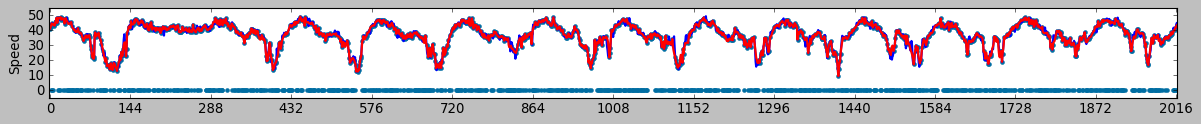

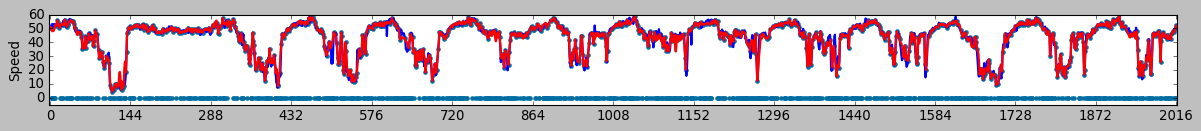

In [12]:
for loc in [0, 1]:
    plt.style.use('classic')
    fig = plt.figure(figsize = (15, 1.5))
    ax = fig.add_axes([0.04, 0.18, 0.94, 0.75])
    plt.plot(sparse_mat[loc, :], '.', markersize = 7, color = "#006ea3")
    plt.plot(dense_mat[loc, :], color = 'blue', linewidth = 2)
    plt.plot(mat_hat[loc, :], color = 'red', linewidth = 2)
    plt.xticks(np.arange(0, 144 * 61 + 1, 144))
    plt.xlim([-2, 144 * 14 + 1])
    if loc == 0:
        plt.ylim([-5, 55])
    elif loc == 1:
        plt.ylim([-5, 60])
    plt.ylabel('Speed')
    plt.show()

In [34]:
import time
start = time.time()
rho = 2e-2
lambda0 = 1 * rho
epsilon = 1e-4
maxiter = 100
mat_hat, U, A, pinv_Phi = lamc_imputer(dense_mat, sparse_mat, rho, lambda0, 
                                       epsilon, maxiter, rank = 214, bidirection = False)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 1
Tolerance: 0.798144
MAPE: 0.278791
RMSE: 10.409

Iter: 2
Tolerance: 0.247375
MAPE: 0.160239
RMSE: 12.506

Iter: 3
Tolerance: 0.037384
MAPE: 0.135027
RMSE: 13.253

Iter: 4
Tolerance: 0.115053
MAPE: 0.118969
RMSE: 18.2448

Iter: 5
Tolerance: 0.0747906
MAPE: 0.10625
RMSE: 14.6245

Iter: 6
Tolerance: 0.0226543
MAPE: 0.0973648
RMSE: 13.5802

Iter: 7
Tolerance: 0.0323125
MAPE: 0.0908372
RMSE: 12.0339

Iter: 8
Tolerance: 0.0222268
MAPE: 0.0861048
RMSE: 10.9804

Iter: 9
Tolerance: 0.0198062
MAPE: 0.0825875
RMSE: 10.0454

Iter: 10
Tolerance: 0.018389
MAPE: 0.0799211
RMSE: 9.18218

Iter: 11
Tolerance: 0.0167528
MAPE: 0.077862
RMSE: 8.40251

Iter: 12
Tolerance: 0.0149669
MAPE: 0.0762449
RMSE: 7.7136

Iter: 13
Tolerance: 0.0132255
MAPE: 0.0749537
RMSE: 7.11278

Iter: 14
Tolerance: 0.0116399
MAPE: 0.0739072
RMSE: 6.59195

Iter: 15
Tolerance: 0.0102518
MAPE: 0.0730465
RMSE: 6.14102

Iter: 16
Tolerance: 0.00906184
MAPE: 0.0723279
RMSE: 5.74995

Iter: 17
Tolerance: 0.00805
MAPE: 0.0717216
RMSE

In [65]:
import time
start = time.time()
rho = 2e-2
lambda0 = 1 * rho
epsilon = 1e-4
maxiter = 100
mat_hat, U, A, pinv_Phi = lamc_imputer(dense_mat, sparse_mat, rho, lambda0, 
                                       epsilon, maxiter, rank = 214, bidirection = False)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 1
Tolerance: 0.798144
MAPE: 0.278791
RMSE: 10.409

Iter: 2
Tolerance: 0.206969
MAPE: 0.158243
RMSE: 10.5411

Iter: 3
Tolerance: 0.0307071
MAPE: 0.130708
RMSE: 10.5018

Iter: 4
Tolerance: 0.281896
MAPE: 0.113092
RMSE: 6.38878

Iter: 5
Tolerance: 0.0551994
MAPE: 0.101025
RMSE: 4.44313

Iter: 6
Tolerance: 0.073446
MAPE: 0.0928478
RMSE: 4.00341

Iter: 7
Tolerance: 0.0194857
MAPE: 0.0870043
RMSE: 3.55153

Iter: 8
Tolerance: 0.00769242
MAPE: 0.0828844
RMSE: 3.37589

Iter: 9
Tolerance: 0.0048488
MAPE: 0.0798868
RMSE: 3.26843

Iter: 10
Tolerance: 0.00373396
MAPE: 0.0776497
RMSE: 3.19254

Iter: 11
Tolerance: 0.0030029
MAPE: 0.0759432
RMSE: 3.13646

Iter: 12
Tolerance: 0.00246214
MAPE: 0.0746149
RMSE: 3.09388

Iter: 13
Tolerance: 0.00204964
MAPE: 0.0735591
RMSE: 3.06078

Iter: 14
Tolerance: 0.0017309
MAPE: 0.0727049
RMSE: 3.03449

Iter: 15
Tolerance: 0.00148215
MAPE: 0.0720016
RMSE: 3.01319

Iter: 16
Tolerance: 0.00128588
MAPE: 0.071414
RMSE: 2.99564

Iter: 17
Tolerance: 0.0011293
MAPE: 0.

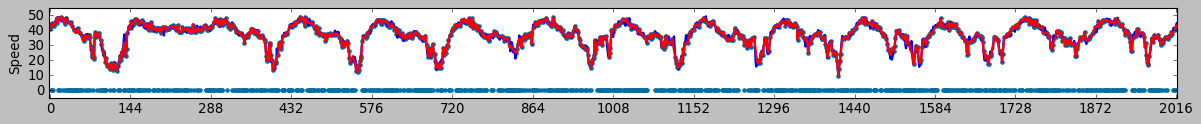

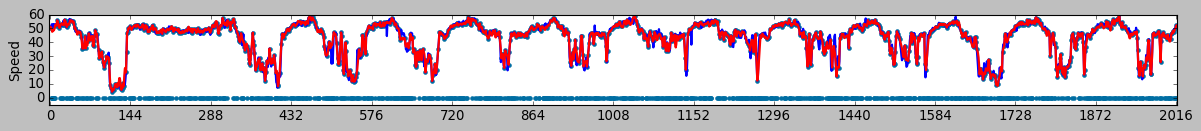

In [33]:
for loc in [0, 1]:
    plt.style.use('classic')
    fig = plt.figure(figsize = (15, 1.5))
    ax = fig.add_axes([0.04, 0.18, 0.94, 0.75])
    plt.plot(sparse_mat[loc, :], '.', markersize = 7, color = "#006ea3")
    plt.plot(dense_mat[loc, :], color = 'blue', linewidth = 2)
    plt.plot(mat_hat[loc, :], color = 'red', linewidth = 2)
    plt.xticks(np.arange(0, 144 * 61 + 1, 144))
    plt.xlim([-2, 144 * 14 + 1])
    if loc == 0:
        plt.ylim([-5, 55])
    elif loc == 1:
        plt.ylim([-5, 60])
    plt.ylabel('Speed')
    plt.show()

In [119]:
import time
start = time.time()
rho = 1e-2
lambda0 = 10 * rho
epsilon = 1e-4
maxiter = 100
mat_hat, U, A, pinv_Phi = lamc_imputer(dense_mat, sparse_mat, rho, lambda0, 
                                       epsilon, maxiter, rank = 214, bidirection = False)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 1
Tolerance: 0.797392
MAPE: 0.267029
RMSE: 10.0068

Iter: 2
Tolerance: 0.181111
MAPE: 0.105011
RMSE: 4.34062

Iter: 3
Tolerance: 0.092237
MAPE: 0.109379
RMSE: 4.77098

Iter: 4
Tolerance: 0.0556419
MAPE: 0.103402
RMSE: 4.65487

Iter: 5
Tolerance: 0.0559076
MAPE: 0.0859501
RMSE: 3.90424

Iter: 6
Tolerance: 0.049649
MAPE: 0.0797727
RMSE: 3.5424

Iter: 7
Tolerance: 0.0410716
MAPE: 0.0787187
RMSE: 3.45557

Iter: 8
Tolerance: 0.0353189
MAPE: 0.0775664
RMSE: 3.41174

Iter: 9
Tolerance: 0.0324177
MAPE: 0.0763161
RMSE: 3.37318

Iter: 10
Tolerance: 0.0301889
MAPE: 0.075475
RMSE: 3.34394

Iter: 11
Tolerance: 0.0283358
MAPE: 0.0749753
RMSE: 3.32728

Iter: 12
Tolerance: 0.0264845
MAPE: 0.0746105
RMSE: 3.31077

Iter: 13
Tolerance: 0.0248818
MAPE: 0.0744011
RMSE: 3.30105

Iter: 14
Tolerance: 0.0232564
MAPE: 0.074217
RMSE: 3.29386

Iter: 15
Tolerance: 0.0218353
MAPE: 0.0740569
RMSE: 3.28411

Iter: 16
Tolerance: 0.0204373
MAPE: 0.0738957
RMSE: 3.27792

Iter: 17
Tolerance: 0.0191961
MAPE: 0.073766

In [141]:
import time
start = time.time()
rho = 1e-3
lambda0 = 0 * rho
epsilon = 1e-4
maxiter = 100
mat_hat, U, A, pinv_Phi = lamc_imputer(dense_mat, sparse_mat, rho, lambda0, 
                                       epsilon, maxiter, rank = 214, bidirection = False)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 1
Tolerance: 0.80704
MAPE: 0.174429
RMSE: 6.57154

Iter: 2
Tolerance: 0.152738
MAPE: 0.113175
RMSE: 4.55629

Iter: 3
Tolerance: 0.0706222
MAPE: 0.105276
RMSE: 4.41298

Iter: 4
Tolerance: 0.0487493
MAPE: 0.100299
RMSE: 4.26418

Iter: 5
Tolerance: 0.0382497
MAPE: 0.0976001
RMSE: 4.14175

Iter: 6
Tolerance: 0.0232358
MAPE: 0.0981244
RMSE: 4.12026

Iter: 7
Tolerance: 0.0133372
MAPE: 0.0995498
RMSE: 4.14152

Iter: 8
Tolerance: 0.00690527
MAPE: 0.100618
RMSE: 4.16441

Iter: 9
Tolerance: 0.00373221
MAPE: 0.101135
RMSE: 4.17722

Iter: 10
Tolerance: 0.00202704
MAPE: 0.101279
RMSE: 4.18148

Iter: 11
Tolerance: 0.00116833
MAPE: 0.10126
RMSE: 4.18148

Iter: 12
Tolerance: 0.000711293
MAPE: 0.1012
RMSE: 4.18021

Iter: 13
Tolerance: 0.000445493
MAPE: 0.101151
RMSE: 4.17902

Iter: 14
Tolerance: 0.000285584
MAPE: 0.101122
RMSE: 4.17825

Iter: 15
Tolerance: 0.000191935
MAPE: 0.101109
RMSE: 4.17785

Iter: 16
Tolerance: 0.000137407
MAPE: 0.101105
RMSE: 4.17767

Iter: 17
Tolerance: 0.000103442
MAPE: 

**Experiment results**:

|  Model |   mape (%) |      rmse | running time|
|:-------------|-----------:|----------:|------------:|
|**LAMC-BiDMD**|   **6.51** |   **2.82**|   81 seconds|
|  LAMC-DMD|   7.29 |   3.24|   46 seconds|
|      LRMC|  10.11 |   4.18|   18 seconds|
|      BTMF|   7.68 |   3.32| 8622 seconds|


**Case**: Nonrandom missing data (40% missing rate) imputation on the Guangzhou traffic speed data set.

In [66]:
import scipy.io

tensor = scipy.io.loadmat('../datasets/Guangzhou-data-set/tensor.mat')
tensor = tensor['tensor']
random_matrix = scipy.io.loadmat('../datasets/Guangzhou-data-set/random_matrix.mat')
random_matrix = random_matrix['random_matrix']

dense_mat = tensor.reshape([tensor.shape[0], tensor.shape[1] * tensor.shape[2]])
missing_rate = 0.4

### Non-random missing (NM) scenario
binary_tensor = np.zeros(tensor.shape)
for i1 in range(tensor.shape[0]):
    for i2 in range(tensor.shape[1]):
        binary_tensor[i1, i2, :] = np.round(random_matrix[i1, i2] + 0.5 - missing_rate)
binary_mat = binary_tensor.reshape([binary_tensor.shape[0], binary_tensor.shape[1] * binary_tensor.shape[2]])

sparse_mat = np.multiply(dense_mat, binary_mat)

In [14]:
import time
start = time.time()
rho = 2e-3
lambda0 = 5 * rho
epsilon = 1e-4
maxiter = 100
mat_hat, U, A, pinv_Phi = lamc_imputer(dense_mat, sparse_mat, rho, lambda0, 
                                       epsilon, maxiter, rank = sparse_mat.shape[0], bidirection = True)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 1
Tolerance: 0.804546
MAPE: 0.211223
RMSE: 8.01219

Iter: 2
Tolerance: 0.115261
MAPE: 0.158653
RMSE: 6.20406

Iter: 3
Tolerance: 0.0592101
MAPE: 0.131729
RMSE: 5.25048

Iter: 4
Tolerance: 0.0347602
MAPE: 0.118252
RMSE: 4.78947

Iter: 5
Tolerance: 0.0222155
MAPE: 0.11095
RMSE: 4.54975

Iter: 6
Tolerance: 0.016347
MAPE: 0.106795
RMSE: 4.41661

Iter: 7
Tolerance: 0.0140752
MAPE: 0.104302
RMSE: 4.32919

Iter: 8
Tolerance: 0.0141858
MAPE: 0.103197
RMSE: 4.29073

Iter: 9
Tolerance: 0.0159865
MAPE: 0.102532
RMSE: 4.26047

Iter: 10
Tolerance: 0.0191658
MAPE: 0.102648
RMSE: 4.26491

Iter: 11
Tolerance: 0.0235542
MAPE: 0.102772
RMSE: 4.26181

Iter: 12
Tolerance: 0.0291839
MAPE: 0.10367
RMSE: 4.29804

Iter: 13
Tolerance: 0.0357186
MAPE: 0.104458
RMSE: 4.31986

Iter: 14
Tolerance: 0.0428861
MAPE: 0.106287
RMSE: 4.39553

Iter: 15
Tolerance: 0.0497299
MAPE: 0.107888
RMSE: 4.44739

Iter: 16
Tolerance: 0.0559102
MAPE: 0.110624
RMSE: 4.55981

Iter: 17
Tolerance: 0.0608334
MAPE: 0.112689
RMSE: 4.6

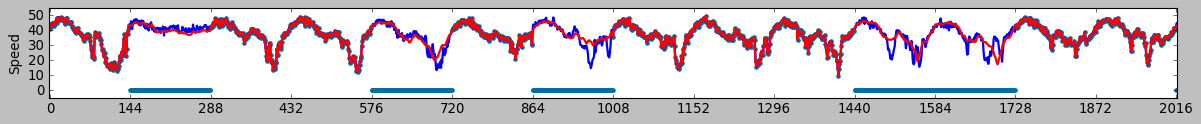

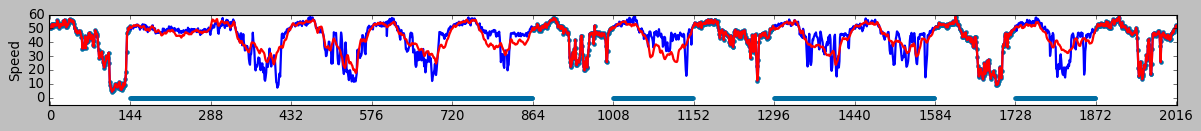

In [15]:
for loc in [0, 1]:
    plt.style.use('classic')
    fig = plt.figure(figsize = (15, 1.5))
    ax = fig.add_axes([0.04, 0.18, 0.94, 0.75])
    plt.plot(sparse_mat[loc, :], '.', markersize = 7, color = "#006ea3")
    plt.plot(dense_mat[loc, :], color = 'blue', linewidth = 2)
    plt.plot(mat_hat[loc, :], color = 'red', linewidth = 2)
    plt.xticks(np.arange(0, 144 * 61 + 1, 144))
    plt.xlim([-2, 144 * 14 + 1])
    if loc == 0:
        plt.ylim([-5, 55])
    elif loc == 1:
        plt.ylim([-5, 60])
    plt.ylabel('Speed')
    plt.show()

In [47]:
import time
start = time.time()
rho = 5e-3
lambda0 = 1 * rho
epsilon = 1e-4
maxiter = 100
mat_hat, U, A, pinv_Phi = lamc_imputer(dense_mat, sparse_mat, rho, lambda0, 
                                       epsilon, maxiter, rank = 214, bidirection = False)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 1
Tolerance: 0.801645
MAPE: 0.254188
RMSE: 9.53035

Iter: 2
Tolerance: 0.13807
MAPE: 0.226484
RMSE: 9.75032

Iter: 3
Tolerance: 0.0806647
MAPE: 0.202215
RMSE: 7.90385

Iter: 4
Tolerance: 0.0333825
MAPE: 0.182926
RMSE: 7.06563

Iter: 5
Tolerance: 0.0207013
MAPE: 0.16761
RMSE: 6.48617

Iter: 6
Tolerance: 0.0139968
MAPE: 0.155625
RMSE: 6.04622

Iter: 7
Tolerance: 0.0114097
MAPE: 0.146286
RMSE: 5.69989

Iter: 8
Tolerance: 0.00958648
MAPE: 0.138993
RMSE: 5.42682

Iter: 9
Tolerance: 0.0080723
MAPE: 0.133278
RMSE: 5.21224

Iter: 10
Tolerance: 0.00681289
MAPE: 0.128764
RMSE: 5.04374

Iter: 11
Tolerance: 0.00576899
MAPE: 0.125168
RMSE: 4.91117

Iter: 12
Tolerance: 0.00490465
MAPE: 0.12228
RMSE: 4.80648

Iter: 13
Tolerance: 0.00418852
MAPE: 0.119941
RMSE: 4.72336

Iter: 14
Tolerance: 0.00359399
MAPE: 0.118028
RMSE: 4.65698

Iter: 15
Tolerance: 0.00309905
MAPE: 0.116452
RMSE: 4.60358

Iter: 16
Tolerance: 0.00268569
MAPE: 0.115142
RMSE: 4.56032

Iter: 17
Tolerance: 0.00233926
MAPE: 0.114047


In [68]:
import time
start = time.time()
rho = 1e-2
lambda0 = 1 * rho
epsilon = 1e-4
maxiter = 100
mat_hat, U, A, pinv_Phi = lamc_imputer(dense_mat, sparse_mat, rho, lambda0, 
                                       epsilon, maxiter, rank = 214, bidirection = False)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 1
Tolerance: 0.801434
MAPE: 0.271124
RMSE: 10.1191

Iter: 2
Tolerance: 0.0323914
MAPE: 0.254221
RMSE: 9.52071

Iter: 3
Tolerance: 0.0135206
MAPE: 0.239478
RMSE: 9.0087

Iter: 4
Tolerance: 0.0119931
MAPE: 0.22641
RMSE: 8.55462

Iter: 5
Tolerance: 0.0108279
MAPE: 0.214753
RMSE: 8.14927

Iter: 6
Tolerance: 0.00980814
MAPE: 0.204377
RMSE: 7.7875

Iter: 7
Tolerance: 0.00889711
MAPE: 0.19516
RMSE: 7.46491

Iter: 8
Tolerance: 0.00807819
MAPE: 0.186993
RMSE: 7.17749

Iter: 9
Tolerance: 0.00734021
MAPE: 0.179771
RMSE: 6.92158

Iter: 10
Tolerance: 0.00667442
MAPE: 0.173387
RMSE: 6.69382

Iter: 11
Tolerance: 0.0060735
MAPE: 0.167746
RMSE: 6.49114

Iter: 12
Tolerance: 0.00553105
MAPE: 0.162759
RMSE: 6.31077

Iter: 13
Tolerance: 0.00504143
MAPE: 0.15835
RMSE: 6.15018

Iter: 14
Tolerance: 0.00459955
MAPE: 0.154444
RMSE: 6.00713

Iter: 15
Tolerance: 0.00420083
MAPE: 0.150982
RMSE: 5.87959

Iter: 16
Tolerance: 0.00384104
MAPE: 0.147905
RMSE: 5.76578

Iter: 17
Tolerance: 0.00351636
MAPE: 0.145167

In [134]:
import time
start = time.time()
rho = 2e-3
lambda0 = 1 * rho
epsilon = 1e-4
maxiter = 100
mat_hat, U, A, pinv_Phi = lamc_imputer(dense_mat, sparse_mat, rho, lambda0, 
                                       epsilon, maxiter, rank = 214, bidirection = False)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 1
Tolerance: 0.804546
MAPE: 0.211223
RMSE: 8.01219

Iter: 2
Tolerance: 0.114214
MAPE: 0.158202
RMSE: 6.27146

Iter: 3
Tolerance: 0.156659
MAPE: 0.206852
RMSE: 9.19356

Iter: 4
Tolerance: 0.0653731
MAPE: 0.17081
RMSE: 7.62049

Iter: 5
Tolerance: 0.0390474
MAPE: 0.146442
RMSE: 6.43061

Iter: 6
Tolerance: 0.031773
MAPE: 0.128148
RMSE: 5.48598

Iter: 7
Tolerance: 0.0224001
MAPE: 0.117513
RMSE: 4.9343

Iter: 8
Tolerance: 0.0155704
MAPE: 0.111607
RMSE: 4.63517

Iter: 9
Tolerance: 0.0105828
MAPE: 0.108434
RMSE: 4.48139

Iter: 10
Tolerance: 0.0070597
MAPE: 0.106756
RMSE: 4.40381

Iter: 11
Tolerance: 0.00465543
MAPE: 0.105867
RMSE: 4.36423

Iter: 12
Tolerance: 0.00306555
MAPE: 0.105393
RMSE: 4.34332

Iter: 13
Tolerance: 0.0020405
MAPE: 0.10513
RMSE: 4.33169

Iter: 14
Tolerance: 0.00138816
MAPE: 0.104975
RMSE: 4.32484

Iter: 15
Tolerance: 0.00097082
MAPE: 0.10488
RMSE: 4.32056

Iter: 16
Tolerance: 0.000698839
MAPE: 0.104816
RMSE: 4.31775

Iter: 17
Tolerance: 0.000517133
MAPE: 0.104773
RMSE

In [136]:
import time
start = time.time()
rho = 2e-3
lambda0 = 0 * rho
epsilon = 1e-4
maxiter = 100
mat_hat, U, A, pinv_Phi = lamc_imputer(dense_mat, sparse_mat, rho, lambda0, 
                                       epsilon, maxiter, rank = 214, bidirection = False)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 1
Tolerance: 0.804546
MAPE: 0.211223
RMSE: 8.01219

Iter: 2
Tolerance: 0.108838
MAPE: 0.160601
RMSE: 6.27827

Iter: 3
Tolerance: 0.0500204
MAPE: 0.134838
RMSE: 5.31922

Iter: 4
Tolerance: 0.0288303
MAPE: 0.12212
RMSE: 4.84593

Iter: 5
Tolerance: 0.0168227
MAPE: 0.115464
RMSE: 4.61482

Iter: 6
Tolerance: 0.0107658
MAPE: 0.111813
RMSE: 4.50014

Iter: 7
Tolerance: 0.00711743
MAPE: 0.10976
RMSE: 4.44086

Iter: 8
Tolerance: 0.00483686
MAPE: 0.108571
RMSE: 4.40861

Iter: 9
Tolerance: 0.00340571
MAPE: 0.107856
RMSE: 4.39009

Iter: 10
Tolerance: 0.00250237
MAPE: 0.107402
RMSE: 4.37885

Iter: 11
Tolerance: 0.00191848
MAPE: 0.107099
RMSE: 4.37166

Iter: 12
Tolerance: 0.0015256
MAPE: 0.106887
RMSE: 4.36685

Iter: 13
Tolerance: 0.00124848
MAPE: 0.106732
RMSE: 4.3635

Iter: 14
Tolerance: 0.00104399
MAPE: 0.106615
RMSE: 4.36109

Iter: 15
Tolerance: 0.000887194
MAPE: 0.106524
RMSE: 4.35931

Iter: 16
Tolerance: 0.000763259
MAPE: 0.106451
RMSE: 4.35795

Iter: 17
Tolerance: 0.000662987
MAPE: 0.106

**Experiment results**:

|  Model |   mape (%) |      rmse | running time|
|:-------------|-----------:|----------:|------------:|
|**LAMC-BiDMD**|  **10.21** |   **4.23**|   91 seconds|
|  LAMC-DMD|  10.47 |   4.31|   23 seconds|
|      LRMC|  10.60 |   4.35|   31 seconds|
|      BTMF|  10.18 |   4.31| 1358 seconds|


**Case**: Block missing data (20% missing rate) imputation on the Guangzhou traffic speed data set.

In [55]:
import numpy as np
import scipy.io
np.random.seed(1000)

block_len = 6

tensor = scipy.io.loadmat('../datasets/Guangzhou-data-set/tensor.mat')
tensor = tensor['tensor']
dense_mat = tensor.reshape([tensor.shape[0], tensor.shape[1] * tensor.shape[2]])
rand_vec = np.random.rand(int(dense_mat.shape[1] / block_len))

missing_rate = 0.2

### Non-random missing (NM) scenario
binary_mat = np.zeros(dense_mat.shape)
for i1 in range(dense_mat.shape[0]):
    for i2 in range(int(dense_mat.shape[1] / block_len)):
        binary_mat[i1, i2 * block_len : (i2 + 1) * block_len] = np.round(rand_vec[i2] + 0.5 - missing_rate)
sparse_mat = np.multiply(dense_mat, binary_mat)

In [17]:
import time
start = time.time()
rho = 1e-2
lambda0 = 1 * rho
epsilon = 1e-4
maxiter = 100
mat_hat, U, A, pinv_Phi = lamc_imputer(dense_mat, sparse_mat, rho, lambda0, 
                                       epsilon, maxiter, rank = 214, bidirection = True)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 1
Tolerance: 0.516874
MAPE: 0.281262
RMSE: 10.8042

Iter: 2
Tolerance: 0.0523009
MAPE: 0.23144
RMSE: 9.12688

Iter: 3
Tolerance: 0.0262823
MAPE: 0.205561
RMSE: 8.08424

Iter: 4
Tolerance: 0.020402
MAPE: 0.184431
RMSE: 7.32867

Iter: 5
Tolerance: 0.0167433
MAPE: 0.171003
RMSE: 6.78229

Iter: 6
Tolerance: 0.0139309
MAPE: 0.15955
RMSE: 6.39048

Iter: 7
Tolerance: 0.0120966
MAPE: 0.152261
RMSE: 6.10466

Iter: 8
Tolerance: 0.0109548
MAPE: 0.145942
RMSE: 5.89393

Iter: 9
Tolerance: 0.0102671
MAPE: 0.141788
RMSE: 5.73273

Iter: 10
Tolerance: 0.00982123
MAPE: 0.138035
RMSE: 5.60871

Iter: 11
Tolerance: 0.00943696
MAPE: 0.135413
RMSE: 5.5074

Iter: 12
Tolerance: 0.00899463
MAPE: 0.132953
RMSE: 5.42576

Iter: 13
Tolerance: 0.00843178
MAPE: 0.131136
RMSE: 5.35512

Iter: 14
Tolerance: 0.00773615
MAPE: 0.129405
RMSE: 5.29642

Iter: 15
Tolerance: 0.00692542
MAPE: 0.128063
RMSE: 5.24383

Iter: 16
Tolerance: 0.00603847
MAPE: 0.126787
RMSE: 5.19939

Iter: 17
Tolerance: 0.0051223
MAPE: 0.125758
RM

In [62]:
import time
start = time.time()
rho = 1e-2
lambda0 = 0.5 * rho
epsilon = 1e-4
maxiter = 100
mat_hat, U, A, pinv_Phi = lamc_imputer(dense_mat, sparse_mat, rho, lambda0, 
                                       epsilon, maxiter, rank = 214, bidirection = False)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 1
Tolerance: 0.516874
MAPE: 0.281262
RMSE: 10.8042

Iter: 2
Tolerance: 0.0355942
MAPE: 0.260708
RMSE: 10.0733

Iter: 3
Tolerance: 0.00731159
MAPE: 0.253255
RMSE: 9.82583

Iter: 4
Tolerance: 0.00553446
MAPE: 0.246969
RMSE: 9.61993

Iter: 5
Tolerance: 0.00476422
MAPE: 0.241422
RMSE: 9.43801

Iter: 6
Tolerance: 0.00427992
MAPE: 0.236411
RMSE: 9.2717

Iter: 7
Tolerance: 0.0038969
MAPE: 0.231868
RMSE: 9.11893

Iter: 8
Tolerance: 0.0035684
MAPE: 0.22774
RMSE: 8.97858

Iter: 9
Tolerance: 0.00328521
MAPE: 0.223977
RMSE: 8.84939

Iter: 10
Tolerance: 0.0030385
MAPE: 0.220534
RMSE: 8.73017

Iter: 11
Tolerance: 0.00281992
MAPE: 0.217372
RMSE: 8.61992

Iter: 12
Tolerance: 0.00262342
MAPE: 0.21446
RMSE: 8.51779

Iter: 13
Tolerance: 0.00244505
MAPE: 0.211773
RMSE: 8.42306

Iter: 14
Tolerance: 0.00228212
MAPE: 0.209287
RMSE: 8.33508

Iter: 15
Tolerance: 0.00213265
MAPE: 0.206986
RMSE: 8.25328

Iter: 16
Tolerance: 0.0019951
MAPE: 0.204852
RMSE: 8.17715

Iter: 17
Tolerance: 0.0018682
MAPE: 0.20286

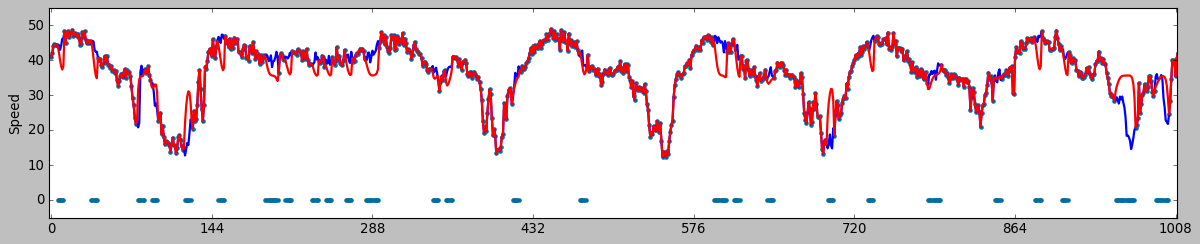

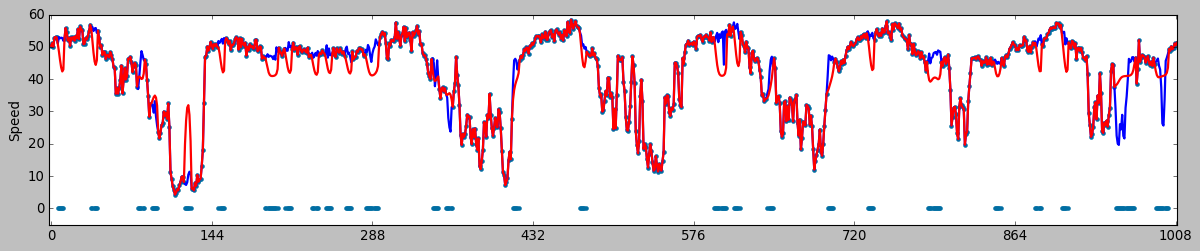

In [58]:
for loc in [0, 1]:
    plt.style.use('classic')
    fig = plt.figure(figsize = (15, 3.5))
    ax = fig.add_axes([0.04, 0.18, 0.94, 0.75])
    plt.plot(sparse_mat[loc, :], '.', markersize = 7, color = "#006ea3")
    plt.plot(dense_mat[loc, :], color = 'blue', linewidth = 2)
    plt.plot(mat_hat[loc, :], color = 'red', linewidth = 2)
    plt.xticks(np.arange(0, 144 * 61 + 1, 144))
    plt.xlim([-2, 144 * 7 + 1])
    if loc == 0:
        plt.ylim([-5, 55])
    elif loc == 1:
        plt.ylim([-5, 60])
    plt.ylabel('Speed')
    plt.show()

#### Hangzhou passenger flow data

In [24]:
import scipy.io

tensor = scipy.io.loadmat('../datasets/Hangzhou-data-set/tensor.mat')
tensor = tensor['tensor']
random_matrix = scipy.io.loadmat('../datasets/Hangzhou-data-set/random_matrix.mat')
random_matrix = random_matrix['random_matrix']
random_tensor = scipy.io.loadmat('../datasets/Hangzhou-data-set/random_tensor.mat')
random_tensor = random_tensor['random_tensor']

dense_mat = tensor.reshape([tensor.shape[0], tensor.shape[1] * tensor.shape[2]])
missing_rate = 0.4

# =============================================================================
### Random missing (RM) scenario
### Set the RM scenario by:
binary_mat = (np.round(random_tensor + 0.5 - missing_rate)
              .reshape([random_tensor.shape[0], random_tensor.shape[1] * random_tensor.shape[2]]))
# =============================================================================

# =============================================================================
### Non-random missing (NM) scenario
### Set the NM scenario by:
# binary_tensor = np.zeros(tensor.shape)
# for i1 in range(tensor.shape[0]):
#     for i2 in range(tensor.shape[1]):
#         binary_tensor[i1, i2, :] = np.round(random_matrix[i1, i2] + 0.5 - missing_rate)
# binary_mat = binary_tensor.reshape([binary_tensor.shape[0], binary_tensor.shape[1] * binary_tensor.shape[2]])
# =============================================================================

sparse_mat = np.multiply(dense_mat, binary_mat)

In [33]:
import time
start = time.time()
rho = 1e-3
lambda0 = 1 * rho
epsilon = 1e-4
maxiter = 100
mat_hat, U, A, pinv_Phi = lamc_imputer(dense_mat, sparse_mat, rho, lambda0, 
                                       epsilon, maxiter, rank = sparse_mat.shape[0], bidirection = True)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 1
Tolerance: 0.526458
MAPE: 3.1195
RMSE: 155.88

Iter: 2
Tolerance: 0.398966
MAPE: 1.28317
RMSE: 68.4717

Iter: 3
Tolerance: 0.180592
MAPE: 0.612265
RMSE: 40.5154

Iter: 4
Tolerance: 0.0779593
MAPE: 0.464041
RMSE: 36.052

Iter: 5
Tolerance: 0.0443519
MAPE: 0.346047
RMSE: 33.6006

Iter: 6
Tolerance: 0.0263853
MAPE: 0.288878
RMSE: 32.5419

Iter: 7
Tolerance: 0.0176638
MAPE: 0.267412
RMSE: 32.2323

Iter: 8
Tolerance: 0.012835
MAPE: 0.251569
RMSE: 32.0906

Iter: 9
Tolerance: 0.0100036
MAPE: 0.240718
RMSE: 32.1086

Iter: 10
Tolerance: 0.00815016
MAPE: 0.232803
RMSE: 32.0912

Iter: 11
Tolerance: 0.00679369
MAPE: 0.229113
RMSE: 32.128

Iter: 12
Tolerance: 0.00565405
MAPE: 0.226539
RMSE: 32.1213

Iter: 13
Tolerance: 0.00466081
MAPE: 0.226081
RMSE: 32.1425

Iter: 14
Tolerance: 0.00374879
MAPE: 0.225356
RMSE: 32.1366

Iter: 15
Tolerance: 0.00294875
MAPE: 0.225519
RMSE: 32.1471

Iter: 16
Tolerance: 0.0022481
MAPE: 0.225223
RMSE: 32.1433

Iter: 17
Tolerance: 0.00166694
MAPE: 0.225411
RMSE: 3

In [44]:
import time
start = time.time()
rho = 1e-3
lambda0 = 1 * rho
epsilon = 1e-4
maxiter = 100
mat_hat, U, A, pinv_Phi = lamc_imputer(dense_mat, sparse_mat, rho, lambda0, 
                                       epsilon, maxiter, rank = sparse_mat.shape[0], bidirection = False)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 1
Tolerance: 0.526458
MAPE: 3.1195
RMSE: 155.88

Iter: 2
Tolerance: 0.318625
MAPE: 1.56763
RMSE: 86.8148

Iter: 3
Tolerance: 0.153691
MAPE: 0.826445
RMSE: 57.1286

Iter: 4
Tolerance: 0.0767234
MAPE: 0.570474
RMSE: 45.25

Iter: 5
Tolerance: 0.0442779
MAPE: 0.445214
RMSE: 40.2059

Iter: 6
Tolerance: 0.0267996
MAPE: 0.370235
RMSE: 37.9902

Iter: 7
Tolerance: 0.01716
MAPE: 0.323121
RMSE: 36.9507

Iter: 8
Tolerance: 0.0123318
MAPE: 0.289302
RMSE: 36.3917

Iter: 9
Tolerance: 0.00945086
MAPE: 0.266131
RMSE: 36.0515

Iter: 10
Tolerance: 0.00662195
MAPE: 0.253111
RMSE: 35.8479

Iter: 11
Tolerance: 0.00418644
MAPE: 0.247242
RMSE: 35.7267

Iter: 12
Tolerance: 0.00262658
MAPE: 0.244434
RMSE: 35.6476

Iter: 13
Tolerance: 0.00173807
MAPE: 0.243016
RMSE: 35.5921

Iter: 14
Tolerance: 0.00121183
MAPE: 0.242283
RMSE: 35.5519

Iter: 15
Tolerance: 0.00087499
MAPE: 0.241915
RMSE: 35.5222

Iter: 16
Tolerance: 0.000647039
MAPE: 0.241763
RMSE: 35.4998

Iter: 17
Tolerance: 0.000487033
MAPE: 0.241675
RMSE

In [40]:
import time
start = time.time()
rho = 1e-4
lambda0 = 0 * rho
epsilon = 1e-4
maxiter = 100
mat_hat, U, A, pinv_Phi = lamc_imputer(dense_mat, sparse_mat, rho, lambda0, 
                                       epsilon, maxiter, rank = sparse_mat.shape[0], bidirection = False)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 1
Tolerance: 0.630173
MAPE: 1.68365
RMSE: 128.465

Iter: 2
Tolerance: 0.367858
MAPE: 0.621413
RMSE: 100.543

Iter: 3
Tolerance: 0.180667
MAPE: 0.549548
RMSE: 88.3863

Iter: 4
Tolerance: 0.0875721
MAPE: 0.516215
RMSE: 81.1017

Iter: 5
Tolerance: 0.0703096
MAPE: 0.43311
RMSE: 74.9931

Iter: 6
Tolerance: 0.0570726
MAPE: 0.372279
RMSE: 70.5761

Iter: 7
Tolerance: 0.0425605
MAPE: 0.335648
RMSE: 67.6488

Iter: 8
Tolerance: 0.0327283
MAPE: 0.313655
RMSE: 65.671

Iter: 9
Tolerance: 0.031963
MAPE: 0.297028
RMSE: 64.2536

Iter: 10
Tolerance: 0.0276591
MAPE: 0.283714
RMSE: 63.249

Iter: 11
Tolerance: 0.0238916
MAPE: 0.272866
RMSE: 62.52

Iter: 12
Tolerance: 0.0206398
MAPE: 0.263854
RMSE: 61.972

Iter: 13
Tolerance: 0.0167596
MAPE: 0.256835
RMSE: 61.5357

Iter: 14
Tolerance: 0.0150419
MAPE: 0.250549
RMSE: 61.1664

Iter: 15
Tolerance: 0.01221
MAPE: 0.245092
RMSE: 60.8482

Iter: 16
Tolerance: 0.0100755
MAPE: 0.240508
RMSE: 60.5844

Iter: 17
Tolerance: 0.0070673
MAPE: 0.237061
RMSE: 60.372

Ite

#### Seattle freeway traffic speed data

In [45]:
import pandas as pd

dense_mat = pd.read_csv('../datasets/Seattle-data-set/mat.csv', index_col = 0)
NM_mat = pd.read_csv('../datasets/Seattle-data-set/NM_mat.csv', index_col = 0)
dense_mat = dense_mat.values
NM_mat = NM_mat.values

missing_rate = 0.4

# =============================================================================
### Random missing (RM) scenario
### Set the RM scenario by:
# binary_mat = np.round(RM_mat + 0.5 - missing_rate)
# =============================================================================

# =============================================================================
### Non-random missing (NM) scenario
### Set the NM scenario by:
binary_tensor = np.zeros((dense_mat.shape[0], 28, 288))
for i1 in range(binary_tensor.shape[0]):
    for i2 in range(binary_tensor.shape[1]):
        binary_tensor[i1, i2, :] = np.round(NM_mat[i1, i2] + 0.5 - missing_rate)
# =============================================================================

sparse_mat = np.multiply(dense_mat, binary_tensor.reshape([dense_mat.shape[0], dense_mat.shape[1]]))

In [46]:
import time
start = time.time()
rho = 1e-3
lambda0 = 1 * rho
epsilon = 1e-4
maxiter = 100
mat_hat, U, A, pinv_Phi = lamc_imputer(dense_mat, sparse_mat, rho, lambda0, 
                                       epsilon, maxiter, rank = sparse_mat.shape[0], bidirection = True)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 1
Tolerance: 0.798045
MAPE: 0.189654
RMSE: 8.53079

Iter: 2
Tolerance: 0.261423
MAPE: 0.357651
RMSE: 19.9187

Iter: 3
Tolerance: 0.0852451
MAPE: 0.316838
RMSE: 18.8116

Iter: 4
Tolerance: 0.064409
MAPE: 0.290052
RMSE: 17.8791

Iter: 5
Tolerance: 0.0815592
MAPE: 0.284771
RMSE: 18.3412

Iter: 6
Tolerance: 0.0363406
MAPE: 0.254778
RMSE: 16.5279

Iter: 7
Tolerance: 0.0314826
MAPE: 0.227758
RMSE: 14.8186

Iter: 8
Tolerance: 0.0302125
MAPE: 0.200107
RMSE: 13.042

Iter: 9
Tolerance: 0.0278678
MAPE: 0.174969
RMSE: 11.3878

Iter: 10
Tolerance: 0.0257131
MAPE: 0.153138
RMSE: 9.91159

Iter: 11
Tolerance: 0.0231266
MAPE: 0.134663
RMSE: 8.6264

Iter: 12
Tolerance: 0.0203248
MAPE: 0.119676
RMSE: 7.5507

Iter: 13
Tolerance: 0.0176984
MAPE: 0.107904
RMSE: 6.68274

Iter: 14
Tolerance: 0.0151448
MAPE: 0.0989869
RMSE: 6.01234

Iter: 15
Tolerance: 0.0126739
MAPE: 0.0925228
RMSE: 5.51859

Iter: 16
Tolerance: 0.0103404
MAPE: 0.088061
RMSE: 5.17111

Iter: 17
Tolerance: 0.00824663
MAPE: 0.0850965
RMSE: 

In [73]:
import pandas as pd

dense_mat = pd.read_csv('../datasets/Seattle-data-set/mat.csv', index_col = 0)
NM_mat = pd.read_csv('../datasets/Seattle-data-set/NM_mat.csv', index_col = 0)
dense_mat = dense_mat.values
NM_mat = NM_mat.values

missing_rate = 0.7

# =============================================================================
### Random missing (RM) scenario
### Set the RM scenario by:
# binary_mat = np.round(RM_mat + 0.5 - missing_rate)
# =============================================================================

# =============================================================================
### Non-random missing (NM) scenario
### Set the NM scenario by:
binary_tensor = np.zeros((dense_mat.shape[0], 28, 288))
for i1 in range(binary_tensor.shape[0]):
    for i2 in range(binary_tensor.shape[1]):
        binary_tensor[i1, i2, :] = np.round(NM_mat[i1, i2] + 0.5 - missing_rate)
# =============================================================================

sparse_mat = np.multiply(dense_mat, binary_tensor.reshape([dense_mat.shape[0], dense_mat.shape[1]]))

In [78]:
import time
start = time.time()
rho = 2e-4
lambda0 = 0.5 * rho
epsilon = 1e-4
maxiter = 100
mat_hat, U, A, pinv_Phi = lamc_imputer(dense_mat, sparse_mat, rho, lambda0, 
                                       epsilon, maxiter, rank = sparse_mat.shape[0], bidirection = True)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 1
Tolerance: 1.43623
MAPE: 0.242224
RMSE: 10.5335

Iter: 2
Tolerance: 1.0507
MAPE: 0.70492
RMSE: 42.4229

Iter: 3
Tolerance: 0.403405
MAPE: 0.810772
RMSE: 48.1985

Iter: 4
Tolerance: 0.2541
MAPE: 0.705634
RMSE: 42.2769

Iter: 5
Tolerance: 0.272025
MAPE: 0.614224
RMSE: 37.3362

Iter: 6
Tolerance: 0.2373
MAPE: 0.560486
RMSE: 34.3509

Iter: 7
Tolerance: 0.24472
MAPE: 0.450201
RMSE: 28.107

Iter: 8
Tolerance: 0.205266
MAPE: 0.421406
RMSE: 27.1876

Iter: 9
Tolerance: 0.198732
MAPE: 0.379185
RMSE: 24.1394

Iter: 10
Tolerance: 0.132834
MAPE: 0.347582
RMSE: 22.1966

Iter: 11
Tolerance: 0.122689
MAPE: 0.311828
RMSE: 19.7079

Iter: 12
Tolerance: 0.111879
MAPE: 0.288132
RMSE: 17.9876

Iter: 13
Tolerance: 0.113619
MAPE: 0.258215
RMSE: 15.9389

Iter: 14
Tolerance: 0.103243
MAPE: 0.216469
RMSE: 13.4474

Iter: 15
Tolerance: 0.0772573
MAPE: 0.18921
RMSE: 11.6173

Iter: 16
Tolerance: 0.0655503
MAPE: 0.169838
RMSE: 10.1915

Iter: 17
Tolerance: 0.0590858
MAPE: 0.153948
RMSE: 9.04711

Iter: 18
Toler

#### PeMS traffic speed data

In [48]:
dense_mat = np.load('../datasets/PeMS-data-set/pems.npy')
random_tensor = np.load('../datasets/PeMS-data-set/random_tensor.npy')

missing_rate = 0.5

### Random missing (RM) scenario:
binary_mat = np.round(random_tensor + 0.5 - missing_rate).reshape([dense_mat.shape[0], dense_mat.shape[1]])
sparse_mat = np.multiply(dense_mat, binary_mat)

In [55]:
import time
start = time.time()
rho = 5e-3
lambda0 = 5 * rho
epsilon = 1e-4
maxiter = 100
mat_hat, U, A, pinv_Phi = lamc_imputer(dense_mat, sparse_mat, rho, lambda0, 
                                       epsilon, maxiter, rank = sparse_mat.shape[0], bidirection = True)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 1
Tolerance: 0.975282
MAPE: 0.254373
RMSE: 12.4907

Iter: 2
Tolerance: 0.147294
MAPE: 0.103872
RMSE: 5.90525

Iter: 3
Tolerance: 0.0881151
MAPE: 0.0697967
RMSE: 4.41972

Iter: 4
Tolerance: 0.0432343
MAPE: 0.078213
RMSE: 4.58567

Iter: 5
Tolerance: 0.0321416
MAPE: 0.0638608
RMSE: 3.96911

Iter: 6
Tolerance: 0.0333169
MAPE: 0.0490986
RMSE: 3.30416

Iter: 7
Tolerance: 0.0371333
MAPE: 0.0426942
RMSE: 2.963

Iter: 8
Tolerance: 0.0450587
MAPE: 0.0431175
RMSE: 2.9609

Iter: 9
Tolerance: 0.0582971
MAPE: 0.0483744
RMSE: 3.25787

Iter: 10
Tolerance: 0.0749402
MAPE: 0.0554538
RMSE: 3.76573

Iter: 11
Tolerance: 0.0918677
MAPE: 0.0659048
RMSE: 4.43508

Iter: 12
Tolerance: 0.104993
MAPE: 0.0754193
RMSE: 5.05159

Iter: 13
Tolerance: 0.114363
MAPE: 0.0848006
RMSE: 5.53321

Iter: 14
Tolerance: 0.121293
MAPE: 0.0898232
RMSE: 5.80557

Iter: 15
Tolerance: 0.127591
MAPE: 0.094692
RMSE: 5.99244

Iter: 16
Tolerance: 0.133709
MAPE: 0.0962959
RMSE: 6.09666

Iter: 17
Tolerance: 0.13965
MAPE: 0.0996804
RMS

In [56]:
import time
start = time.time()
rho = 2e-3
lambda0 = 5 * rho
epsilon = 1e-4
maxiter = 100
mat_hat, U, A, pinv_Phi = lamc_imputer(dense_mat, sparse_mat, rho, lambda0, 
                                       epsilon, maxiter, rank = sparse_mat.shape[0], bidirection = False)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 1
Tolerance: 0.979203
MAPE: 0.224542
RMSE: 11.0966

Iter: 2
Tolerance: 0.135809
MAPE: 0.120777
RMSE: 6.72693

Iter: 3
Tolerance: 0.085199
MAPE: 0.0738602
RMSE: 4.92827

Iter: 4
Tolerance: 0.0463701
MAPE: 0.0727765
RMSE: 4.69404

Iter: 5
Tolerance: 0.0361648
MAPE: 0.0614636
RMSE: 4.14253

Iter: 6
Tolerance: 0.0321556
MAPE: 0.0514135
RMSE: 3.6497

Iter: 7
Tolerance: 0.0258992
MAPE: 0.0493646
RMSE: 3.46804

Iter: 8
Tolerance: 0.0210335
MAPE: 0.0494229
RMSE: 3.42133

Iter: 9
Tolerance: 0.0183071
MAPE: 0.0487112
RMSE: 3.3902

Iter: 10
Tolerance: 0.01651
MAPE: 0.0476692
RMSE: 3.362

Iter: 11
Tolerance: 0.0149899
MAPE: 0.0468976
RMSE: 3.34161

Iter: 12
Tolerance: 0.0136656
MAPE: 0.0464637
RMSE: 3.3285

Iter: 13
Tolerance: 0.0124296
MAPE: 0.0462092
RMSE: 3.31935

Iter: 14
Tolerance: 0.0112447
MAPE: 0.0460982
RMSE: 3.31361

Iter: 15
Tolerance: 0.0100959
MAPE: 0.0460002
RMSE: 3.30775

Iter: 16
Tolerance: 0.00893521
MAPE: 0.0459485
RMSE: 3.30507

Iter: 17
Tolerance: 0.00780279
MAPE: 0.04587

### License

<div class="alert alert-block alert-danger">
<b>This work is released under the MIT license.</b>
</div>